# **Trabajo Práctico N°2 - Aprendizaje Automático 1**
**Integrantes**:

Dito, Daniela

Flaibani, Marcela

López Crespo, facundo

## Librerías

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, balanced_accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import cross_val_predict
from scipy.stats import mode
import plotly.graph_objs as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')



## 1. Análisis descriptivo 

### Lectura y primeras manipulaciones del DataSet 

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.shape

(145460, 23)

In [3]:
# Elección aleatoria de 10 ciudades
ciud = pd.Series(df['Location'].unique())
ciud_10 = ciud.sample(n=10,random_state=1)
ciud_10

27        Dartmoor
34       Nuriootpa
39    PerthAirport
48           Uluru
2            Cobar
3     CoffsHarbour
42         Walpole
29          Cairns
45    AliceSprings
30       GoldCoast
dtype: object

Dartmoor, Victoria: Latitud: -37.9167 Longitud: 141.2833

Nuriootpa, South Australia: Latitud: -34.4700 Longitud: 138.9960

Perth Airport, Western Australia: Latitud: -31.9403 Longitud: 115.9668

Uluru, Northern Territory: Latitud: -25.3444 Longitud: 131.0369

Cobar, New South Wales: Latitud: -31.4983 Longitud: 145.8389

Coffs Harbour, New South Wales: Latitud: -30.2963 Longitud: 153.1157

Walpole, Western Australia: Latitud: -34.9780 Longitud: 116.7330

Cairns, Queensland: Latitud: -16.9203 Longitud: 145.7700

Alice Springs, Northern Territory: Latitud: -23.6980 Longitud: 133.8807

Gold Coast, Queensland: Latitud: -28.0167 Longitud: 153.4000

In [4]:
# Filtro del df según ciudades seleccionadas y luego descarto la columna ciudad 
df_weather = df[df['Location'].isin(ciud_10)]
#df_weather = df_weather.drop('Location',axis=1)



In [5]:
ciudades_coords = {
    'Dartmoor': {'Latitud': -37.9167, 'Longitud': 141.2833},
    'Nuriootpa': {'Latitud': -34.4700, 'Longitud': 138.9960},
    'PerthAirport': {'Latitud': -31.9403, 'Longitud': 115.9668},
    'Uluru': {'Latitud': -25.3444, 'Longitud': 131.0369},
    'Cobar': {'Latitud': -31.4983, 'Longitud': 145.8389},
    'CoffsHarbour': {'Latitud': -30.2963, 'Longitud': 153.1157},
    'Walpole': {'Latitud': -34.9780, 'Longitud': 116.7330},
    'Cairns': {'Latitud': -16.9203, 'Longitud': 145.7700},
    'AliceSprings': {'Latitud': -23.6980, 'Longitud': 133.8807},
    'GoldCoast': {'Latitud': -28.0167, 'Longitud': 153.4000}
}

df_weather['Latitude'] = df_weather['Location'].map(lambda loc: ciudades_coords[loc]['Latitud'])
df_weather['Longitude'] = df_weather['Location'].map(lambda loc: ciudades_coords[loc]['Longitud'])
df_weather = df_weather.drop('Location',axis=1)

In [6]:
df_weather.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Latitude', 'Longitude'],
      dtype='object')

El dataset a analizar se compone de observaciones diarias de las siguientes variables meteorológicas:
* **Temperatura**: [MinTemp, MaxTemp, Temp9am, Temp3pm]. Variables cuantitativas continuas. 

* **Lluvia**: 

    [Rainfall]. Variable cuantitavia continua.

    [RainToday, RainTomorrow]. Variable cualitativa nominal.
* **Evaporización**: [Evaporation]. Variable cuantitavia .

* **Luminosidad**: [Sunshine]. Variable cuantitativa. 
* **Viento**: 

    [WindSpeed9am, WindSpeed3pm, WindGustSpeed]. Variables cuantitativas continuas.

    [WindGustDir, WindDir9am, WindDir3pm]. Variables cualitativas nominales
* **Humedad**: [Humidity9am, Humidity3pm]. Variables cuantitativas continuas. 

* **Presión**: [Pressure9am, Pressure3pm]. Variables cuantitativas continuas.  
* **Nubosidad**: [Cloud9am, Cloud3pm]. Variables cuantitativas continuas.  


In [7]:
# Elimino las observaciones cuya variable target tiene valor nulo
df_weather = df_weather.dropna(subset=['RainTomorrow'])

In [8]:
# En relación al tiempo se utilizan las features Date(cuantitativa) y Month(cualitativa)
df_weather['Date']=pd.to_datetime(df_weather['Date'],format='mixed')
df_weather['Month'] = df_weather['Date'].dt.month
meses = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']
month_dict = {}
for i,mes in enumerate(meses):
    month_dict[i+1] = mes
df_weather['Month'] = df_weather['Month'].map(month_dict)    

In [9]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28234 entries, 6049 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           28234 non-null  datetime64[ns]
 1   MinTemp        28193 non-null  float64       
 2   MaxTemp        28211 non-null  float64       
 3   Rainfall       28049 non-null  float64       
 4   Evaporation    18330 non-null  float64       
 5   Sunshine       15473 non-null  float64       
 6   WindGustDir    27545 non-null  object        
 7   WindGustSpeed  27591 non-null  float64       
 8   WindDir9am     26591 non-null  object        
 9   WindDir3pm     27770 non-null  object        
 10  WindSpeed9am   27878 non-null  float64       
 11  WindSpeed3pm   27886 non-null  float64       
 12  Humidity9am    27887 non-null  float64       
 13  Humidity3pm    27881 non-null  float64       
 14  Pressure9am    27926 non-null  float64       
 15  Pressure3pm    27926

In [10]:
df_weather.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Latitude,Longitude,Month
6049,2009-01-01,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,1004.4,2.0,5.0,26.6,33.4,No,No,-31.4983,145.8389,ene
6050,2009-01-02,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,1012.1,1.0,1.0,20.3,27.0,No,No,-31.4983,145.8389,ene
6051,2009-01-03,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,...,1011.6,NaN,1.0,NaN,32.7,No,No,-31.4983,145.8389,ene
6052,2009-01-04,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,1009.2,1.0,6.0,28.7,34.9,No,No,-31.4983,145.8389,ene
6053,2009-01-05,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,1009.1,1.0,5.0,29.1,35.6,No,No,-31.4983,145.8389,ene


### División del DataSet: Train - Test

In [11]:
# División del DF entre train y test VER STRATIFY
X = df_weather.drop(columns='RainTomorrow')
y = df_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22587, 24), (5647, 24), (22587,), (5647,))

In [12]:
#Armo los data frame de entrenamiento y de testeo
df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([y_test,y_test],axis=1)

In [13]:
# Filtro aquellos registros de entrenamiento que no tienen más de 3 features nulas 
# es lo que permite el límite del 5% para eliminar registros del conjunto de entrenamiento
idxs_registros_aceptables = df_train.dropna(thresh=18).index
X_train = X_train.loc[idxs_registros_aceptables]
y_train = y_train.loc[idxs_registros_aceptables]
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [14]:
X_train.shape

(22253, 24)

In [15]:
# Solamente se describen variables cuantitativas
round(X_train.describe(),1)

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Latitude,Longitude
count,22253,22228.0,22236.0,22159.0,14656.0,12411.0,22032.0,22223.0,22223.0,22014.0,22009.0,22208.0,22208.0,13224.0,12828.0,22246.0,22241.0,22253.0,22253.0
mean,2013-05-01 00:43:13.591875072,13.6,25.0,2.6,5.8,8.0,40.1,15.3,19.5,63.6,49.4,1017.5,1014.9,3.9,4.0,19.1,23.5,-29.7,137.9
min,2008-12-01 00:00:00,-5.2,7.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,982.0,985.1,0.0,0.0,-0.3,5.3,-37.9,116.0
25%,2011-02-13 00:00:00,8.8,19.8,0.0,2.8,5.3,31.0,9.0,13.0,50.0,30.0,1013.0,1010.3,1.0,1.0,13.9,18.4,-34.5,131.0
50%,2013-06-26 00:00:00,13.4,24.9,0.0,5.0,9.0,39.0,15.0,19.0,65.0,52.0,1017.4,1014.8,4.0,4.0,19.0,23.2,-31.5,141.3
75%,2015-07-04 00:00:00,18.8,29.9,0.8,8.0,10.9,46.0,20.0,24.0,80.0,66.0,1021.9,1019.3,7.0,7.0,24.2,28.1,-25.3,145.8
max,2017-06-25 00:00:00,31.0,46.6,371.0,86.2,14.3,113.0,72.0,61.0,100.0,100.0,1040.4,1037.7,8.0,8.0,39.4,45.2,-16.9,153.4
std,NaN,6.4,6.9,10.3,4.3,3.7,11.9,8.2,8.2,22.1,23.1,6.6,6.6,2.9,2.8,6.6,6.8,6.0,12.8


In [16]:
# Obtengo el porcentaje de valores faltantes por feature
round(X_train.isna().sum().sort_values(ascending=False) / len(X_train) * 100, 0) 

Sunshine         44.0
Cloud3pm         42.0
Cloud9am         41.0
Evaporation      34.0
WindDir9am        5.0
Humidity3pm       1.0
Humidity9am       1.0
WindGustDir       1.0
WindGustSpeed     1.0
WindDir3pm        0.0
RainToday         0.0
Rainfall          0.0
Pressure3pm       0.0
Pressure9am       0.0
WindSpeed9am      0.0
WindSpeed3pm      0.0
MinTemp           0.0
MaxTemp           0.0
Temp3pm           0.0
Temp9am           0.0
Date              0.0
Latitude          0.0
Longitude         0.0
Month             0.0
dtype: float64

In [17]:
# Interesa distinguir las features cuantitativas de aquellas features cualitativas
features_cuanti = list(X_train.describe().columns)
features_cuali = [feature for feature in X_train.columns if feature not in features_cuanti]
print(f'Features cuantitativas:\n')
[print(feature_cuanti) for feature_cuanti in features_cuanti]
print(f'Features cualitativas:\n')
[print(feature_cuali) for feature_cuali in features_cuali]
# Elimino feature date de cuanti para que después no traiga problemas
features_cuanti.remove('Date')

Features cuantitativas:

Date
MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
Latitude
Longitude
Features cualitativas:

WindGustDir
WindDir9am
WindDir3pm
RainToday
Month


In [18]:
# Las variables cualitativas que presenta el df son de tipo nominal, pues no se pueden ordenar jerárquicamente
[print(f"{feature_cuali}:\n{X_train[feature_cuali].unique()}") for feature_cuali in features_cuali]
    

WindGustDir:
['ESE' 'WSW' 'SSW' 'ENE' 'E' 'SE' 'S' 'WNW' 'W' 'SW' 'N' 'NW' 'SSE' 'NE'
 'NNW' 'NNE' nan]
WindDir9am:
['E' 'S' 'N' 'ESE' 'SE' 'NW' 'NE' nan 'SSE' 'WSW' 'WNW' 'SW' 'SSW' 'NNE'
 'ENE' 'NNW' 'W']
WindDir3pm:
['ESE' 'WSW' 'WNW' 'S' 'SW' 'ENE' 'NE' 'E' 'N' 'SE' 'NW' 'W' 'NNE' 'SSW'
 'NNW' 'SSE' nan]
RainToday:
['No' 'Yes' nan]
Month:
['jun' 'oct' 'feb' 'sep' 'ene' 'mar' 'dic' 'may' 'ago' 'jul' 'nov' 'abr']


[None, None, None, None, None]

In [19]:
# Obtengo el porcentaje de valores atípicos por feature cuantitativa
serie_porcentaje_atipicos = pd.Series()
for feature in features_cuanti:
    serie = X_train[feature]
    q1 , q3 = serie.quantile(q=[0.25,0.75])
    r_i = q3 - q1
    lim_inf = q1 - 1.5 * r_i
    lim_sup = q3 + 1.5 * r_i
    # En caso que trate atípicos puede ser conveniente la línea de abajo
    #feature_idx_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].index
    n_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].count()
    n_no_nan = serie.count()
    porcen_atipicos = round(n_atipicos / n_no_nan * 100,2)  
    serie_porcentaje_atipicos[feature] = porcen_atipicos
serie_porcentaje_atipicos.sort_values(ascending=False) 

Rainfall         18.18
WindGustSpeed     2.64
Evaporation       1.88
WindSpeed3pm      1.52
WindSpeed9am      1.12
Pressure9am       0.79
Pressure3pm       0.59
Humidity9am       0.10
Temp3pm           0.05
MaxTemp           0.01
MinTemp           0.00
Sunshine          0.00
Humidity3pm       0.00
Cloud9am          0.00
Cloud3pm          0.00
Temp9am           0.00
Latitude          0.00
Longitude         0.00
dtype: float64

### Visualización de datos: boxplots, histogramas y scatter plots

In [20]:
def visualizar_features_cuanti_sin_lluvia(tipo_grafico: str) -> None:
    # A la feature lluvia Rainfall se le aplicará un análisis particular
    features_cuanti_sin_lluvia = features_cuanti.copy()
    features_cuanti_sin_lluvia.remove('Rainfall')
    n_features_cuanti_sin_lluvia = len(features_cuanti_sin_lluvia)
    n_col = 3
    n_row = n_features_cuanti_sin_lluvia // n_col if n_features_cuanti_sin_lluvia % n_col == 0 else n_features_cuanti_sin_lluvia // n_col + 1
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col * 5, 5 * n_row))
    titulo = 'Boxplots de las variables predictoras cuantitativas según valor de la variable target' if tipo_grafico == 'boxplots' else "Histogramas de variables cuantitativas"
    fig.suptitle(titulo, fontsize=16)
    fig.subplots_adjust(hspace=0.2)

    # Definir la paleta de colores para 'Yes' y 'No'
    palette = {'Yes': 'red', 'No': 'blue'}

    for i, feature in enumerate(features_cuanti_sin_lluvia):
        # Posición de cada gráfico 
        row = i // n_col
        col = i % n_col
        
        if tipo_grafico == 'boxplots':
            sns.boxplot(data=X_train, x=y_train, y=feature, ax=axes[row, col], palette=palette)
        else:
            sns.histplot(df_train[feature],ax=axes[row, col])  
                # Eliminar subplots vacíos si es necesario
    if n_features_cuanti_sin_lluvia % n_col != 0:
        for i in range(n_features_cuanti_sin_lluvia % n_col, n_col):
            fig.delaxes(axes[n_row - 1, i])

    plt.show()


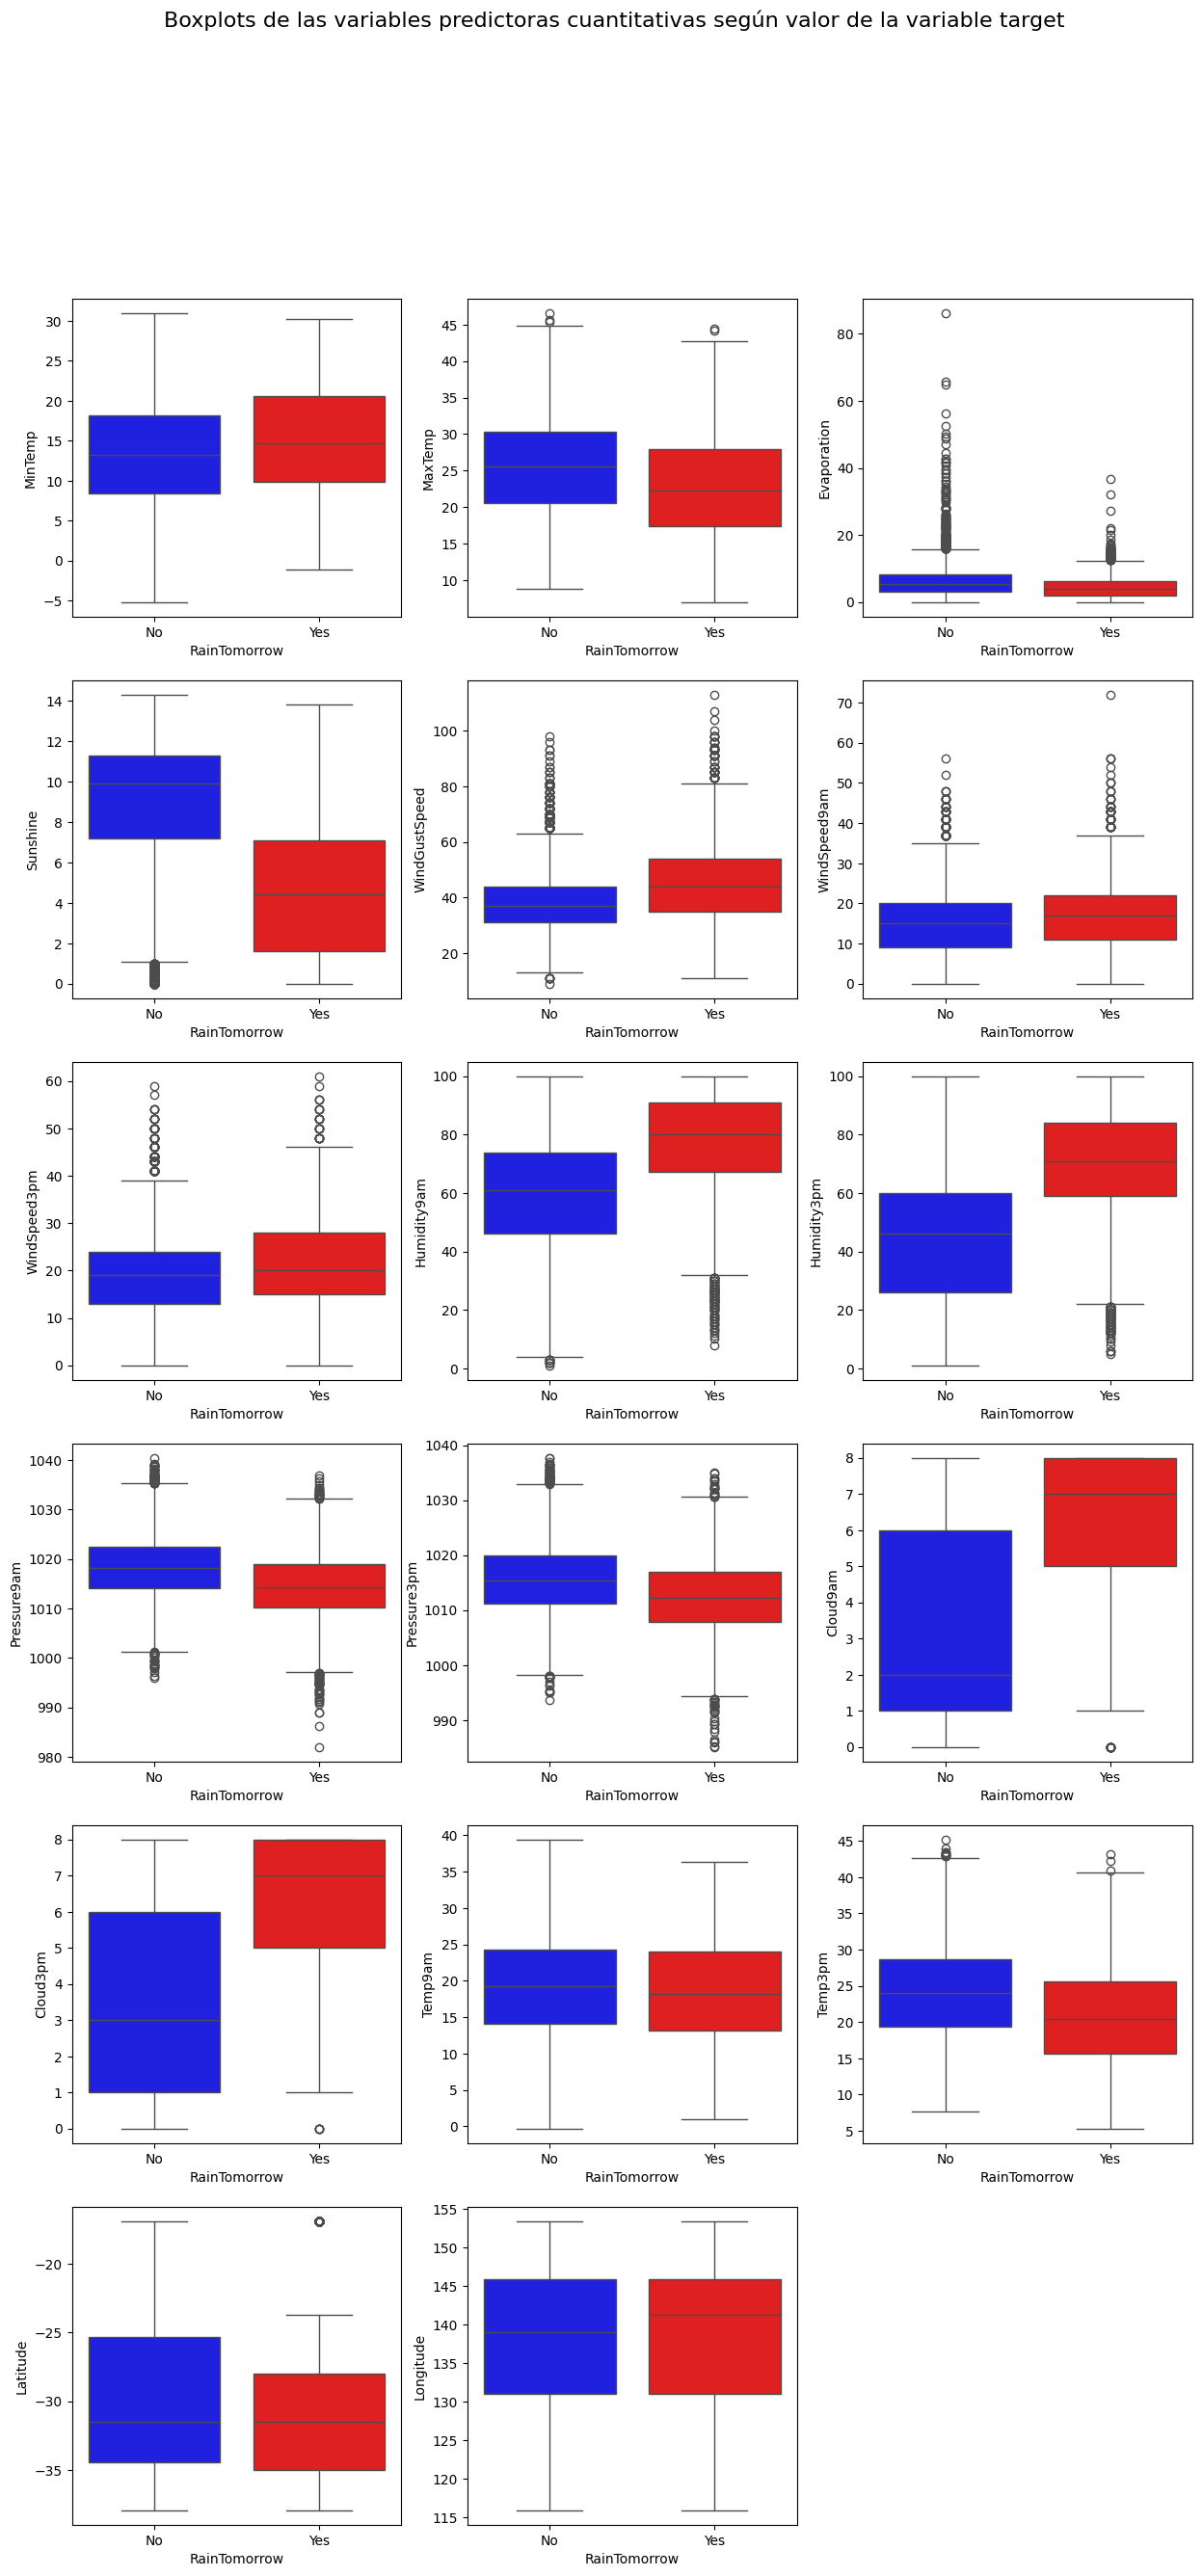

In [21]:
# A la función puede recibir el string boxplots, caso contrario grafica histogramas
visualizar_features_cuanti_sin_lluvia('boxplots')

Se observa que cuando la humedad es mayor al 60% es altamente probable que llueva, pues, cuando no llovió, solamente en el 25% de los casos la humedad presentó un valor mayor a ése, en cambio. Cuando sí llovió, en el 75% de los casos, el valor superó dicha referencia. Esto se informa a modo de justificación acerca de la elección de esta variable para construir el modelo ingenuo solicitado en el punto 3 del TP.

ADVERTENCIA: Se observa que las features vinculadas con la nubosidad (sunshine | cloud 9 am | cloud 3 pm)
son muy importante para explicar la variable target, sin embargo, para un alto porcentaje de las observaciones no se dispone de los datos relativos a la nubosidad. 

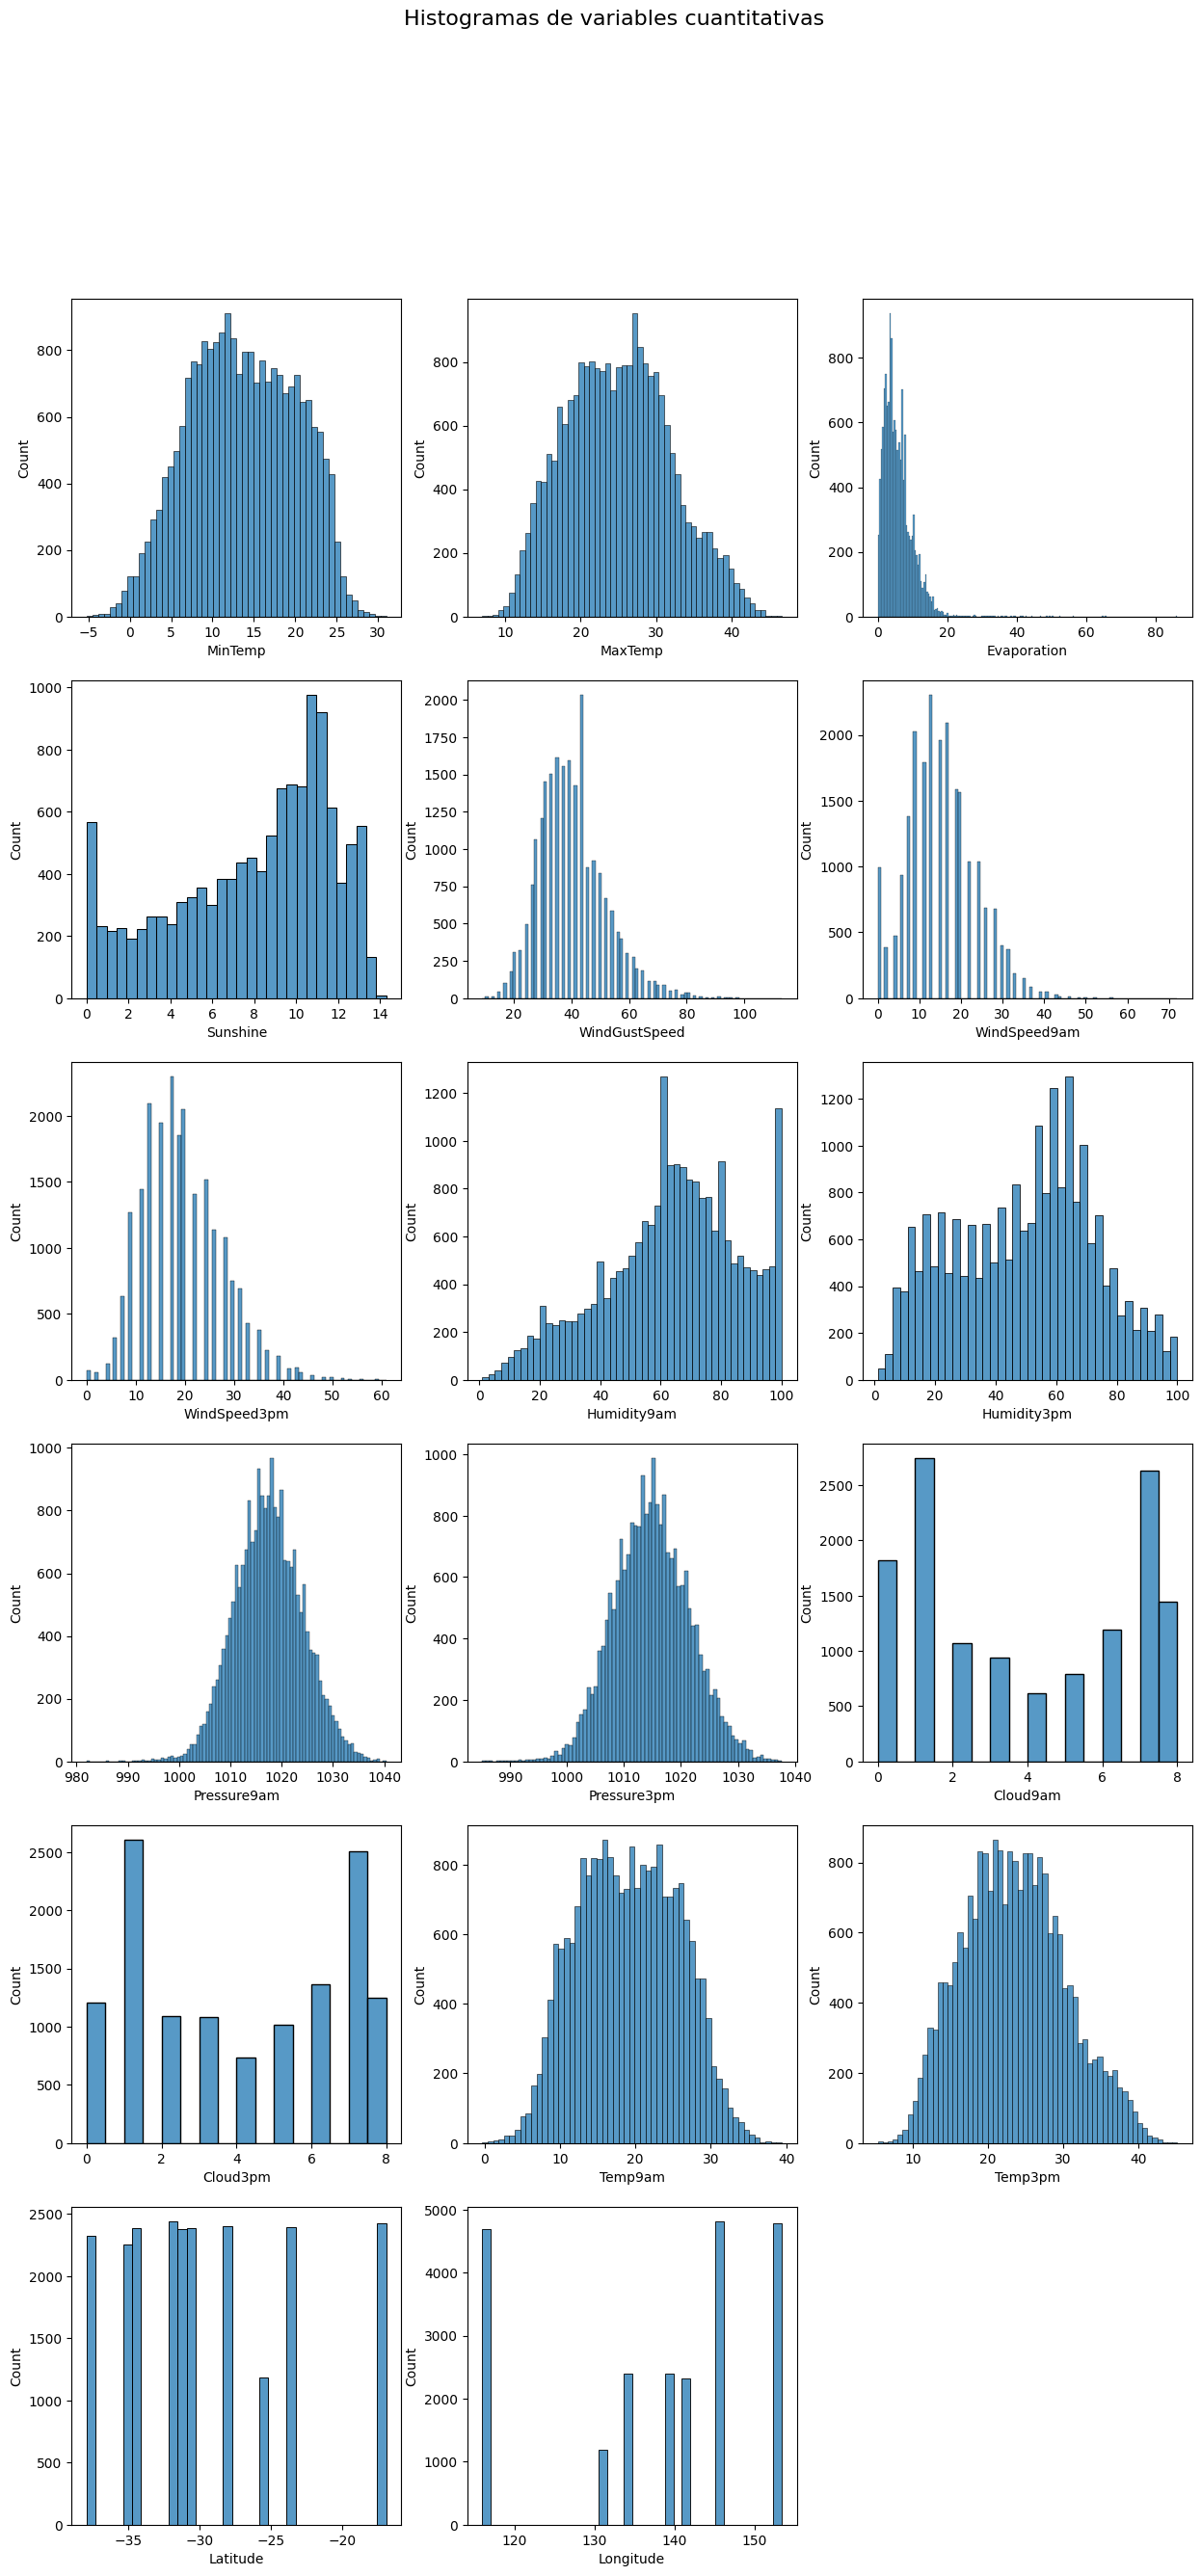

In [22]:
visualizar_features_cuanti_sin_lluvia('histogramas')

El análisis de los histogramas serán tenidos en cuenta para la imputación de faltantes.
Se observa que las siguientes features son 
* simétricas:
Temperatura (en todas sus versiones)
* asimétricas:
Evaporación | Viento (en todas sus versiones) | Humedad (en todas sus versiones) | Presión (en todas sus versiones)
* bimodales:
Nubosidad (en todas sus versiones) | Radiación Solar

Se observa que existe cierto grado de correlación positiva entre esas variables cualitativas

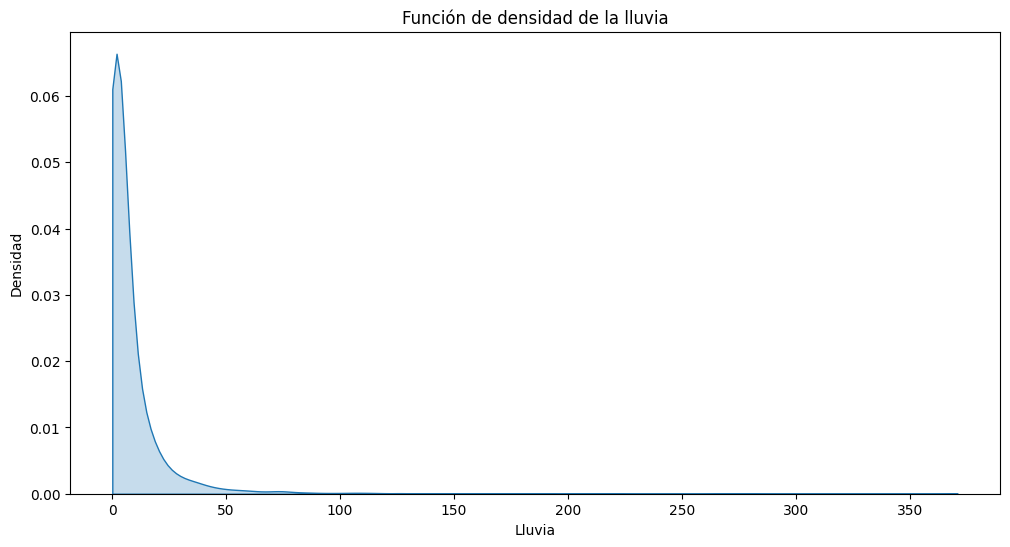

In [23]:
# Se grafica la función de densidad de la feature Rainfall para aquellos días que llovió
s_lluvia = X_train[X_train['Rainfall']>0]['Rainfall']
bandwidth = 1.5
plt.figure(figsize=(12, 6))
sns.kdeplot(data=s_lluvia, fill=True, bw_adjust=bandwidth,cut=0)
plt.title('Función de densidad de la lluvia')
plt.xlabel('Lluvia')
plt.ylabel('Densidad')
current_values = plt.gca().get_xticks()
plt.show()

In [24]:
# Se construye esta tabla para evidenciar la presencia de valores fuertemente atípicos para la variable llvua
rangos_lluvia = pd.cut(s_lluvia,bins=range(0,401,50), right=True)
df_frec_lluvia = rangos_lluvia.value_counts().sort_index().reset_index()
df_frec_lluvia.rename(columns={'Rainfall':'Rainfall','count':'Frecuencia_absoluta'},inplace=True)
df_frec_lluvia.set_index('Rainfall',inplace=True)
df_frec_lluvia['Frecuencia_relativa'] = round(df_frec_lluvia['Frecuencia_absoluta'] / df_frec_lluvia['Frecuencia_absoluta'].sum(),4)
df_frec_lluvia['Frecuencia_absoluta_acumulada'] = df_frec_lluvia['Frecuencia_absoluta'].cumsum()
df_frec_lluvia['Frecuencia_relativa_acumulada'] = df_frec_lluvia['Frecuencia_relativa'].cumsum()
df_frec_lluvia

,Frecuencia_absoluta,Frecuencia_relativa,Frecuencia_absoluta_acumulada,Frecuencia_relativa_acumulada
Rainfall,,,,
"(0, 50]",7467,0.9780,7467,0.9780
"(50, 100]",119,0.0156,7586,0.9936
"(100, 150]",32,0.0042,7618,0.9978
"(150, 200]",11,0.0014,7629,0.9992
"(200, 250]",3,0.0004,7632,0.9996
"(250, 300]",2,0.0003,7634,0.9999
"(300, 350]",0,0.0000,7634,0.9999
"(350, 400]",1,0.0001,7635,1.0000


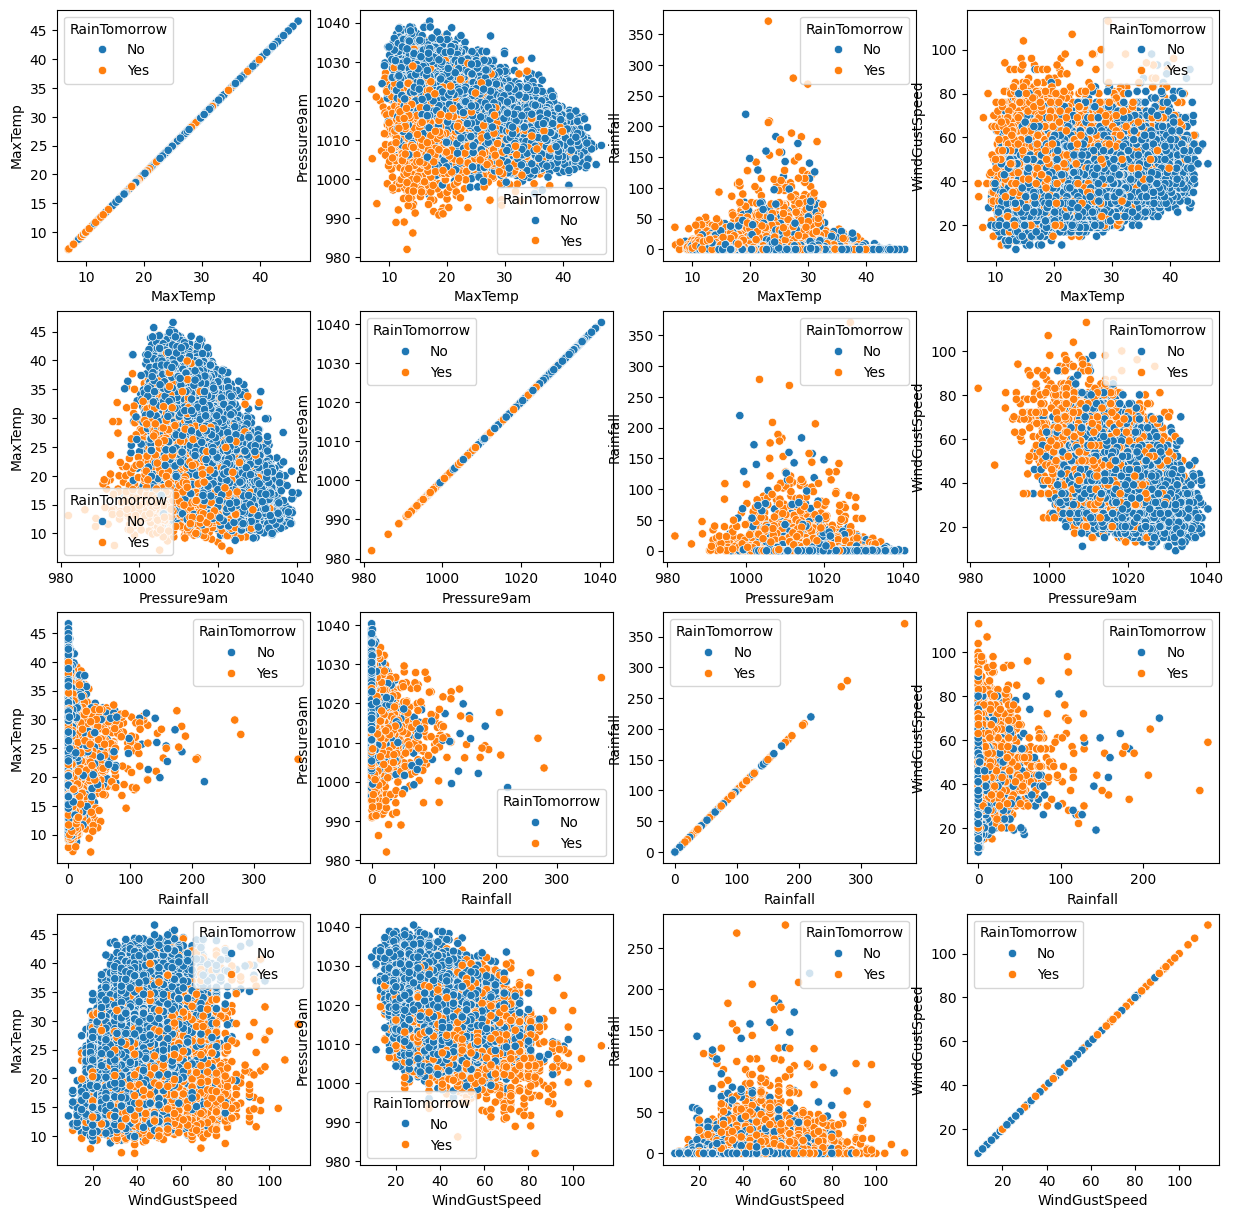

In [25]:
# Por la imposiblidad de ver todos los scatter plot posibles entre cuantitativas, se eligen
#3 features
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
columns = ['MaxTemp','Pressure9am','Rainfall','WindGustSpeed']
fig.subplots_adjust(hspace=0.2)
i = 0
for col in columns:
    j = 0
    for col2 in columns:
        #agregamos labels para usarlas luego
        sns.scatterplot(data=df_train, x=col, y=col2, hue="RainTomorrow",ax=axs[i,j]) 
        j+=1
    i+=1
plt.show()

Se observa a partir de estos gráficos de dispersión la posibilidad de trazar fácilmente una recta frontera en las gráficas, por ejemplo, pressure9am vs máxima temperatura, windgustspeed vs pressure9am y windgustspeed vs máxima temperatura para determinar la pertenencia a una clase de la target. Al contrario, la feature rainfall no sirve para junta a otra feature poder trazar una recta frontera.

In [26]:
# Correlación entre variables cualitativas incluyendo la target
df_corr_rain_cuali = pd.DataFrame({
    'RainToday': ['RainToday_Yes','RainToday_Yes','RainToday_No','RainToday_No'],
    'RainTomorrow': ['RainTomorrow_Yes','RainTomorrow_No','RainTomorrow_Yes','RainTomorrow_No'],
    'Frec_abs': [None,None,None,None]
})
df_corr_rain_cuali.loc[0,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[1,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='No')])
df_corr_rain_cuali.loc[2,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[3,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='No')])

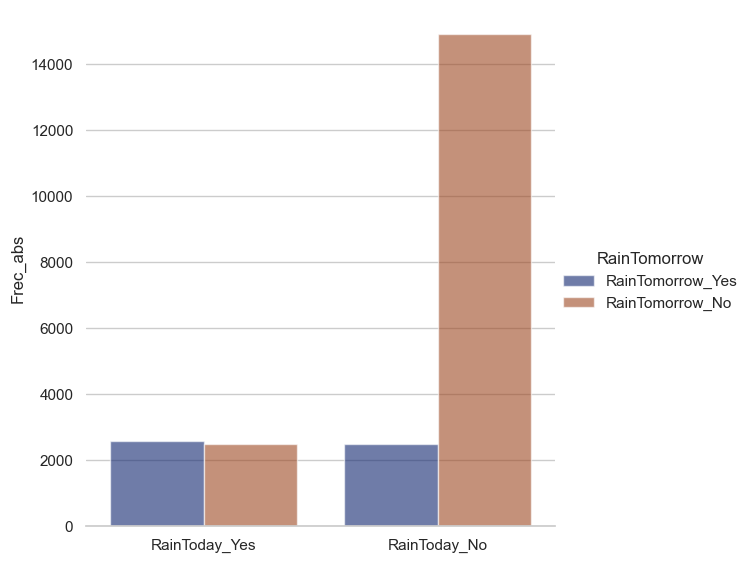

In [27]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df_corr_rain_cuali, kind="bar",
    x="RainToday", y="Frec_abs", hue="RainTomorrow",
    errorbar=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Frec_abs")
g.set_titles('Visualización de correlación entre variables cuantitativas')
plt.show()

Se puede observar la correlación que existe entre raintoday y raintomorrow, si hoy llueve es más probable que mañana también llueva, en cambio, si hoy no llueve, es altamente probable que mañana no llueva. 

### Matriz de correlación de variables

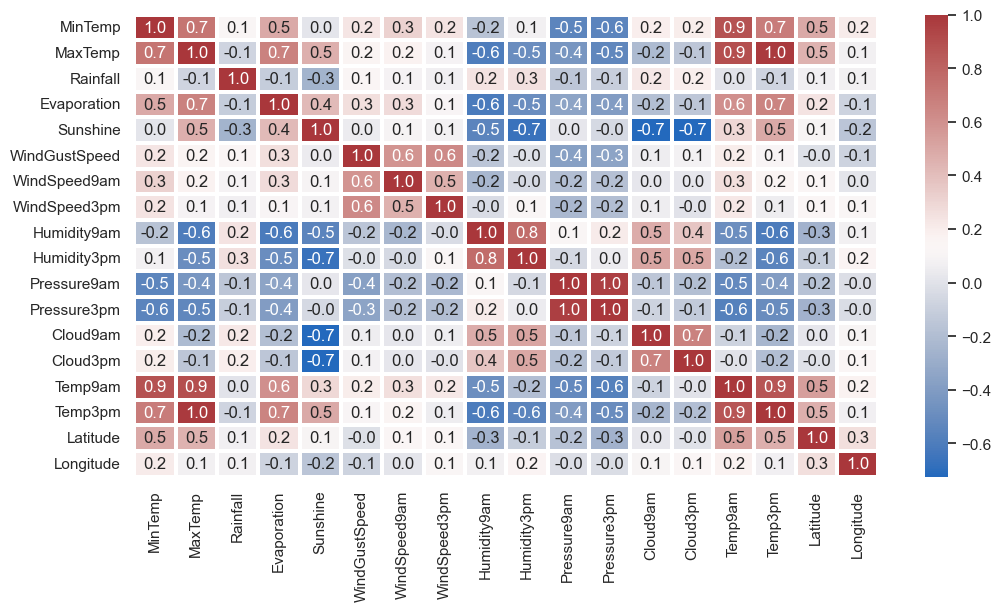

In [28]:
plt.figure(figsize=(12, 6))
sns.heatmap(data=df_train[features_cuanti].corr(),annot=True,fmt=".1f",linewidths=1.5,cmap='vlag')
plt.show()

La colinealidad es un rango entre las features. Por un lado, se observa una correlación lineal positiva fuerte entre variables meteorológicas que únicamente difieren en la hora del día en el que fueron registradas. Por el otro, se verifica una correlación negativa de gran intensidad entre variables que naturalmente tienen comportamientos opuestos como la feature sunshine y las features vinculadas con la medición de la nubosidad.

### Análisis de balanceo del dataset 

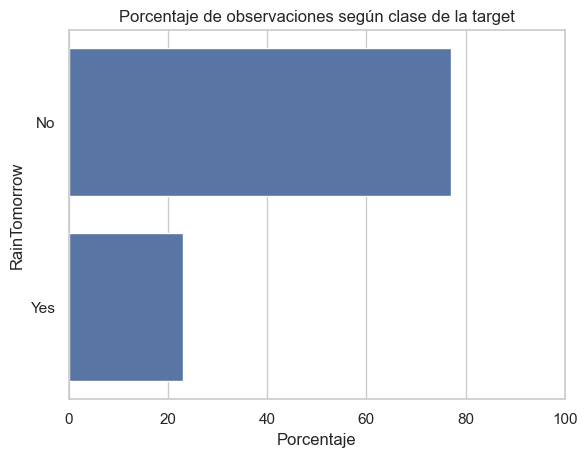

In [29]:
# Análisis de balanceo del df de entrenamiento
balanceo = round(y_train.value_counts() / len(y_train) *100,0)
sns.barplot(balanceo,orient='y')
plt.ylabel('RainTomorrow')
plt.xlabel('Porcentaje')
plt.xlim((0,100))
plt.title('Porcentaje de observaciones según clase de la target')
plt.show()

Clase Raintomorrow = no --> Clase negativa (mayoritaria)

Clase Raintomorrow = si --> Clase positiva (minoritaria)

El dataframe de entrenamiento no está balanceado debido a que más del 75% de las observaciones totales pertenecen a la variable target negativa. Es importante este análisis porque al estar desbalanceado corresponde aplicar las técnicas de oversampling, undersampling o discriminación de penalidad asignada a cada clase para evitar que modelo tienda a predecir la categoría mayoritaria.  

### Análisis y decisión sobre datos faltantes y atípicos

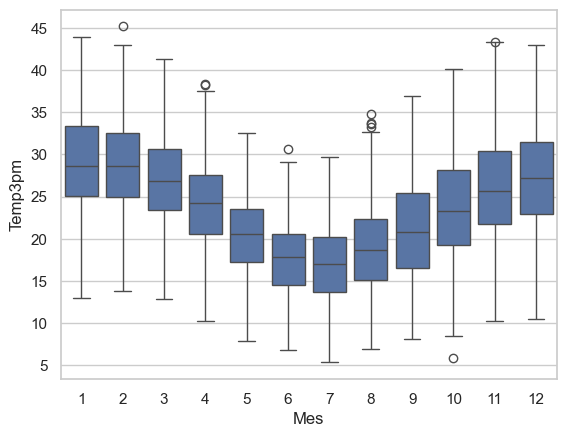

In [30]:
# Se analiza el caso de features que presentan un significativo comportamiento estacional
# y por ende puede que se justifique imputar faltantes aplicando un estadístico segmentado por mes
sns.boxplot(data=df_train,y='Temp3pm',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

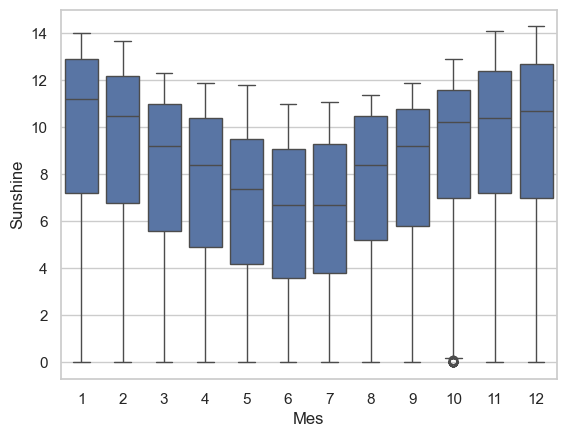

In [31]:
sns.boxplot(data=df_train,y='Sunshine',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

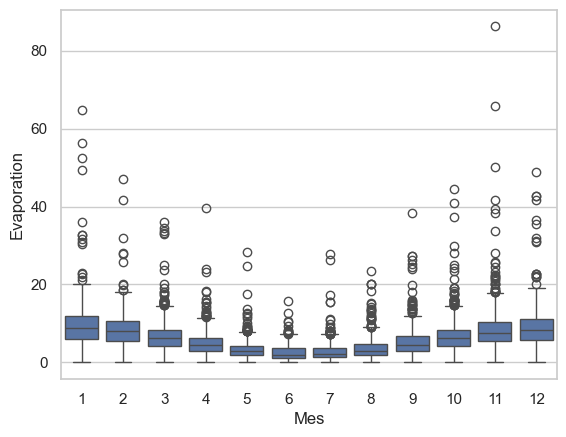

In [32]:
sns.boxplot(data=df_train,y='Evaporation',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

In [33]:
X_train.isna().sum()

Date                0
MinTemp            25
MaxTemp            17
Rainfall           94
Evaporation      7597
Sunshine         9842
WindGustDir       233
WindGustSpeed     221
WindDir9am       1020
WindDir3pm        100
WindSpeed9am       30
WindSpeed3pm       30
Humidity9am       239
Humidity3pm       244
Pressure9am        45
Pressure3pm        45
Cloud9am         9029
Cloud3pm         9425
Temp9am             7
Temp3pm            12
RainToday          94
Latitude            0
Longitude           0
Month               0
dtype: int64

In [34]:
# Tratamiento de faltantes en features con una alta proporción de valores faltantes
# que justifican imputar por media segmentada
X_train_media_seg_sunshine_by_mes = X_train.groupby(X_train['Date'].dt.month)['Sunshine'].transform('mean')
X_train_media_seg_cloud9am_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud9am'].transform('mean')
X_train_media_seg_cloud3pm_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud3pm'].transform('mean')
X_train_media_seg_evaporation_by_mes = X_train.groupby(X_train['Date'].dt.month)['Evaporation'].transform('mean')
X_train_imputed = X_train.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})
X_test_imputed = X_test.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})

In [35]:
# Tratamiento de faltantes en features cualitativas
X_train_moda_dir_nudo_viento = X_train['WindGustDir'].mode()[0]
X_train_moda_dir_viento9am = X_train['WindDir9am'].mode()[0]
X_train_moda_dir_viento3pm = X_train['WindDir3pm'].mode()[0]
X_train_moda_raintoday = X_train['RainToday'].mode()[0]
X_train_imputed = X_train_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})

Función para imputar valores en las columnas de dirección del viento
def impute_wind_directions(row):
    if pd.notna(row['WindGustDir']):
        # Si WindGustDir no es nulo, imputar WindDir9am y WindDir3pm con ese valor
        if pd.isna(row['WindDir9am']):
            row['WindDir9am'] = row['WindGustDir']
        if pd.isna(row['WindDir3pm']):
            row['WindDir3pm'] = row['WindGustDir']
    else:
        # Si WindGustDir es nulo, imputar con los valores entre WindDir9am y WindDir3pm
        if pd.notna(row['WindDir9am']):
            row['WindGustDir'] = row['WindDir9am']
            if pd.isna(row['WindDir3pm']):
                row['WindDir3pm'] = row['WindDir9am']
        elif pd.notna(row['WindDir3pm']):
            row['WindGustDir'] = row['WindDir3pm']
            if pd.isna(row['WindDir9am']):
                row['WindDir9am'] = row['WindDir3pm']
    return row

Aplicar la función a los DataFrames
X_train_imputed = X_train_imputed.apply(impute_wind_directions, axis=1)
X_test_imputed = X_test_imputed.apply(impute_wind_directions, axis=1)

In [36]:
# Reducción de la cantidad de categorías correspondientes con la dirección del viento. De 16 a 4.
direction_dict = {
    'SSW':'S',
    'S':'S',
    'SE':'S',
    'NNE':'N',
    'WNW':'W',
    'N':'N',
    'ENE':'E',
    'NE':'N',
    'E':'E',
    'SW':'S',
    'W':'W',
    'WSW':'W',
    'NNW':'N',
    'ESE':'E',
    'SSE':'S',
    'NW':'N'
}
for feature_cuali in features_cuali[:3]:
    X_train_imputed[feature_cuali] = X_train_imputed[feature_cuali].map(direction_dict)
    X_test_imputed[feature_cuali] = X_test_imputed[feature_cuali].map(direction_dict)
X_train_imputed.loc[0]

Date             2016-06-01 00:00:00
MinTemp                         11.9
MaxTemp                         23.2
Rainfall                         0.0
Evaporation                      2.6
Sunshine                    6.147587
WindGustDir                        E
WindGustSpeed                   30.0
WindDir9am                         E
WindDir3pm                         E
WindSpeed9am                     7.0
WindSpeed3pm                    19.0
Humidity9am                     77.0
Humidity3pm                     61.0
Pressure9am                   1020.9
Pressure3pm                   1018.4
Cloud9am                    4.303057
Cloud3pm                    4.351699
Temp9am                         17.4
Temp3pm                         22.4
RainToday                         No
Latitude                     -23.698
Longitude                   133.8807
Month                            jun
Name: 0, dtype: object

In [37]:
# Tratamiento de faltantes en features asimétricas que justican imputar por mediana simple
X_train_mediana_WindGustSpeed = X_train['WindGustSpeed'].median()
X_train_mediana_Humidity9am = X_train['Humidity9am'].median()
X_train_mediana_Humidity3pm = X_train['Humidity3pm'].median()
X_train_mediana_Rainfall = X_train['Rainfall'].median()
X_train_mediana_WindSpeed9am = X_train['WindSpeed9am'].median()
X_train_mediana_WindSpeed3pm = X_train['WindSpeed3pm'].median()
X_train_mediana_Pressure9am  = X_train['Pressure9am'].median()
X_train_mediana_Pressure3pm = X_train['Pressure3pm'].median()

X_train_imputed = X_train_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})

In [38]:
# Tratamiento de faltantes en features simétricas que justican imputar por media simple
X_train_mean_MinTemp = X_train['MinTemp'].mean()
X_train_mean_MaxTemp = X_train['MaxTemp'].mean()
X_train_mean_Temp9am = X_train['Temp9am'].mean()
X_train_mean_Temp3pm = X_train['Temp3pm'].mean()


X_train_imputed = X_train_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})

In [39]:
X_train_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Latitude         0
Longitude        0
Month            0
dtype: int64

In [40]:
X_test_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Latitude         0
Longitude        0
Month            0
dtype: int64

In [41]:
# Tratamiento de valores atípicos para la feature Rainfall
# La lluvia presenta una significatía asimetría positiva. Para evitar distorsiones sobre el valor de los 
# parámetros del modelo, se imputan los valores atípicos de esta variable en base al mayor valor típico observado 
# para la variable en cuestión.
s_lluvia = X_train_imputed[X_train_imputed['Rainfall']>0]['Rainfall']
q1 , q3 = s_lluvia.quantile(q=[0.25,0.75])
r_i = q3 - q1
valor_tipico_sup = q3 + 1.5 * r_i
# Imputacion para train
X_train_imputed_idx_lluvia_ati = X_train_imputed[X_train_imputed['Rainfall']>valor_tipico_sup].index
X_train_imputed.loc[X_train_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup
# Imputacion para test
X_test_encoded_imputed_idx_lluvia_ati = X_test_imputed[X_test_imputed['Rainfall']>valor_tipico_sup].index
X_test_imputed.loc[X_test_encoded_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup

### Codificación de variables categóricas

In [42]:
def codificar_features_cuanti(data_set,col_catego):
    """Recibe un data frame y sus columnas categoricas y 
    devuelve el data frame transformado con la correspondiente 
    codificación de estas columnas"""
    encoder = OneHotEncoder(sparse_output=False,drop='first')
    one_hot_encoded = encoder.fit_transform(data_set[col_catego])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(col_catego))
    df_encoded = pd.concat([data_set, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(col_catego, axis=1)
    return df_encoded


In [43]:
def codificar_target(serie:pd.Series):
    """Recibe una serie para cambiar el nombre y a su vez mapear 
    sus valores para codificarlos"""
    serie.name ='RainTomorrow_Yes'
    serie_codificada =  serie.map({"No":0,"Yes":1})
    return serie_codificada

In [44]:
#Codificación de features categóricas
X_train_encoded_imputed = codificar_features_cuanti(X_train_imputed,features_cuali)
X_test_encoded_imputed = codificar_features_cuanti(X_test_imputed,features_cuali)

In [45]:
X_train_encoded_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Latitude         0
Longitude        0
WindGustDir_N    0
WindGustDir_S    0
WindGustDir_W    0
WindDir9am_N     0
WindDir9am_S     0
WindDir9am_W     0
WindDir3pm_N     0
WindDir3pm_S     0
WindDir3pm_W     0
RainToday_Yes    0
Month_ago        0
Month_dic        0
Month_ene        0
Month_feb        0
Month_jul        0
Month_jun        0
Month_mar        0
Month_may        0
Month_nov        0
Month_oct        0
Month_sep        0
dtype: int64

In [46]:
#Codificación de la target 
y_train_encoded = codificar_target(y_train)
y_test_encoded = codificar_target(y_test)
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

In [47]:
X_train_encoded_imputed.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Latitude', 'Longitude', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
       'RainToday_Yes', 'Month_ago', 'Month_dic', 'Month_ene', 'Month_feb',
       'Month_jul', 'Month_jun', 'Month_mar', 'Month_may', 'Month_nov',
       'Month_oct', 'Month_sep'],
      dtype='object')

In [48]:
print("X_train_imputed\n",X_train_imputed.head(5))
print("X_train_encoded_imputed\n",X_train_encoded_imputed.head(5))

X_train_imputed
         Date  MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine WindGustDir  \
0 2016-06-01     11.9     23.2       0.0          2.6   6.147587           E   
1 2009-10-13      8.9     20.7       0.0          4.2   8.500000           W   
2 2009-02-28     22.2     36.9       0.0          9.4  12.000000           W   
3 2014-09-12      8.7     21.9       0.0          6.2   7.965803           S   
4 2016-01-22     16.5     30.4       0.0          8.2  13.100000           E   

   WindGustSpeed WindDir9am WindDir3pm  ...  Pressure9am  Pressure3pm  \
0           30.0          E          E  ...       1020.9       1018.4   
1           41.0          S          W  ...       1025.8       1022.8   
2           41.0          N          W  ...       1010.9       1008.1   
3           33.0          E          S  ...       1017.4       1014.8   
4           39.0          E          S  ...       1018.2       1014.8   

   Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  Latitude  L

### Escalado de datos 

In [49]:
# Escalado de datos - NO SE ESCALAN VARIABLES CUALITATIVAS
scaler = StandardScaler()
X_train_encoded_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)
X_test_encoded_imputed_scaled = pd.DataFrame(scaler.transform(X_test_encoded_imputed[features_cuanti]), columns=features_cuanti)


In [50]:
# Primero se filtra para eliminar las cuantitativas no escaladas para luego unir 
# las cualitativas con las cuantitativas sí escaladas
X_train_encoded_imputed_cuali = X_train_encoded_imputed.drop(features_cuanti,axis=1)
X_train_encoded_imputed_cuantiscaled_cuali = pd.concat([X_train_encoded_imputed_scaled,X_train_encoded_imputed_cuali],axis=1)

X_test_encoded_imputed_cuali = X_test_encoded_imputed.drop(features_cuanti,axis=1)
X_test_encoded_imputed_cuantiscaled_cuali = pd.concat([X_test_encoded_imputed_scaled,X_test_encoded_imputed_cuali],axis=1)

In [51]:
X_train_encoded_imputed_cuantiscaled_cuali 
y_test_encoded
X_test_encoded_imputed_cuantiscaled_cuali 
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

## 2. Regresión Logística

Implementamos distintos modelos a los fines de poder comparar las distintas técnicas de optimización:

1 - Modelo de Regresión Logistica Básico.

2- Modelo de Regresión Logistica Balanceado.

3- Modelo de Regresión Logistica Balanceado con Regularización Lasso.

4- Predicciones finales usando los umbrales óptimos.


In [52]:
#Observo columnas de X_train_encoded_imputed_cuantiscaled_cuali
print(X_train_encoded_imputed_cuantiscaled_cuali.columns)
print("Cant. de columnas: ", len(X_train_encoded_imputed_cuantiscaled_cuali.columns))

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Latitude', 'Longitude', 'Date', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
       'RainToday_Yes', 'Month_ago', 'Month_dic', 'Month_ene', 'Month_feb',
       'Month_jul', 'Month_jun', 'Month_mar', 'Month_may', 'Month_nov',
       'Month_oct', 'Month_sep'],
      dtype='object')
Cant. de columnas:  40


In [53]:
# Eliminar la columna 'Date' de los conjuntos ( nos quedamos con los meses)
x_train_clean = X_train_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])
x_test_clean = X_test_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])

# No es necesario modificar y_train y y_test
y_train_clean = y_train_encoded
y_test_clean = y_test_encoded

In [54]:
# Mostrar las dimensiones de X_train_clean
print("Dimensiones de X_train_clean:", x_train_clean.shape)
print("Dimensiones de y_train_clean:", y_train_clean.shape)   # Mostrar las dimensiones de y_train_clean
print("Dimensiones de X_test_clean:", x_test_clean.shape)
print("Dimensiones de y_test_clean:", y_test_clean.shape)


Dimensiones de X_train_clean: (22253, 39)
Dimensiones de y_train_clean: (22253,)
Dimensiones de X_test_clean: (5647, 39)
Dimensiones de y_test_clean: (5647,)


### Regresión Logistica Base (Sin balancear)

In [55]:
# Entrenamos Regresion Logistica básica sin ajustar parametros.
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(x_train_clean, y_train_clean)
y_pred = logistic_model.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred))
print(confusion_matrix(y_test_clean, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4373
           1       0.76      0.56      0.65      1274

    accuracy                           0.86      5647
   macro avg       0.82      0.76      0.78      5647
weighted avg       0.85      0.86      0.85      5647

[[4142  231]
 [ 556  718]]


$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$


In [56]:
# Calcular Balanced Accuracy
balanced_acc_rl = balanced_accuracy_score(y_test_clean, y_pred)
print(f'Balanced Accuracy Reg. Logistica Base: {balanced_acc_rl:.2f}')

Balanced Accuracy Reg. Logistica Base: 0.76


In [57]:
cf_matrix = confusion_matrix(y_test_clean, y_pred)

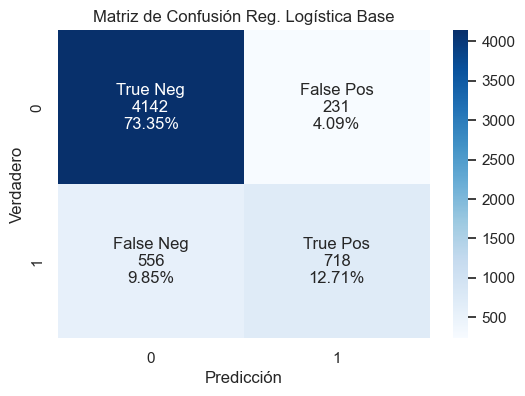

In [58]:
# Matriz de confusión con Heatmap.
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Ajustar el tamaño de la figura
plt.figure(figsize=(6, 4))  
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

plt.title('Matriz de Confusión Reg. Logística Base', fontsize=12)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

Análisis de matriz de confusión:

TN = 4142 Casos donde no llueve y predice que no llueve.

FP = 231 Casos donde no llueve pero predice que llueve.

FN = 556 Casos donde llueve pero predice que no llueve.

TP = 718 Casos donde llueve y predice que llueve correctamente.

##### Curva ROC y AUC 

In [59]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reglog= logistic_model.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_test_clean, y_probs_reglog)
roc_auc_rl = auc(fpr_rl, tpr_rl)

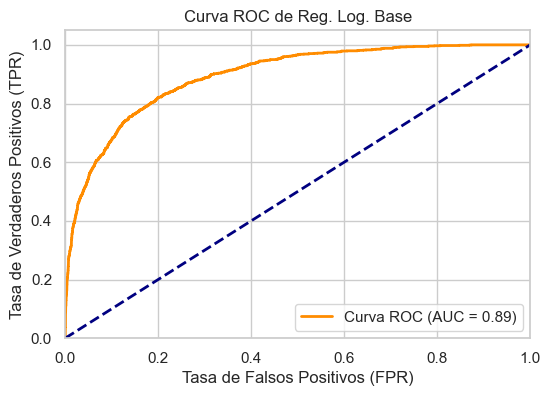

In [60]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_rl, tpr_rl, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_rl)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Base')
plt.legend(loc="lower right")
plt.show()

### Regresión Logística Balanceada.

Class_weight = 'balanced' le asigna pesos distintos en el cálculo de costo para cada clase. En este caso, como la relación de datos es aprox. 77% (clase 0) / 23% (clase minoritaria 1) , el peso para la clase "1" será aproximadamente 3.35 veces mayor que el peso para la clase "0" (penaliza aprox. 3,35 veces más a la clase minoritaria que el de la clase mayoritaria.)

In [61]:
logistic_model_balanced = LogisticRegression(random_state=42, class_weight= "balanced")
logistic_model_balanced.fit(x_train_clean, y_train_clean)
y_pred_balanced = logistic_model_balanced.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred_balanced))
print(confusion_matrix(y_test_clean, y_pred_balanced))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.55      0.81      0.65      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647

[[3523  850]
 [ 242 1032]]


In [62]:
# Calcular Balanced Accuracy
balanced_acc_balanced = balanced_accuracy_score(y_test_clean, y_pred_balanced)

print(f'Balanced Accuracy Reg. Logistica Balanceada: {balanced_acc_balanced:.2f}')

Balanced Accuracy Reg. Logistica Balanceada: 0.81


In [63]:
cf_matrix_b = confusion_matrix(y_test_clean, y_pred_balanced)

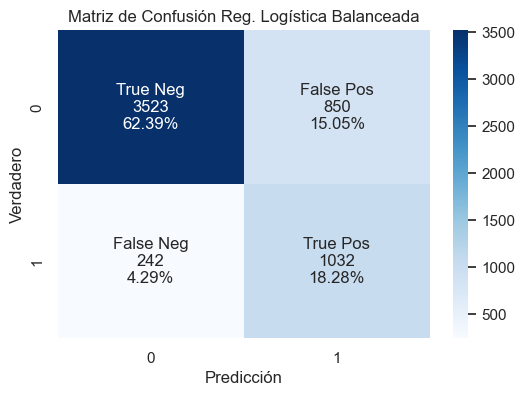

In [64]:
# Matriz de confusión con Heatmap.
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_b.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_b.flatten()/np.sum(cf_matrix_b)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6, 4))  
sns.heatmap(cf_matrix_b, annot=labels, fmt="", cmap='Blues')

plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

##### Curva ROC y AUC 

In [65]:
# Obtengo las probabilidades de predicción del modelo
y_probs_balanced = logistic_model_balanced.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_ba, tpr_ba, thresholds_ba = roc_curve(y_test_clean, y_probs_balanced)
roc_auc = auc(fpr_ba, tpr_ba)

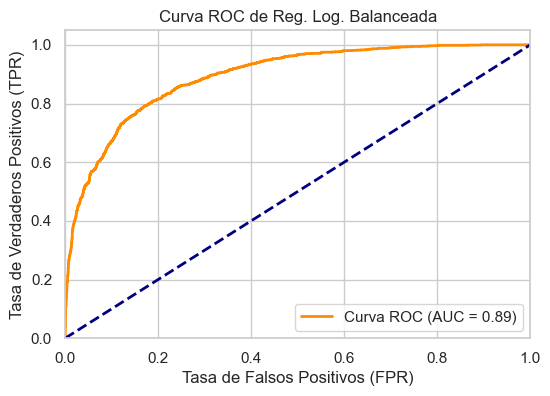

In [66]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_ba, tpr_ba, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada')
plt.legend(loc="lower right")
plt.show()

### Regresión Log. Balanceada con Regularización

In [67]:
# Crear un modelo de regresión logística con regularización L1 (Lasso)
# Ajusta el valor de 'C' para controlar la fuerza de la regularización (menos es más regularización)
# Un valor más pequeño de 'C' aumentará la regularización

logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=1, solver='saga',random_state=42, class_weight= "balanced")
#logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=0.5, solver='saga',random_state=42, class_weight= "balanced")
#logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=1.5, solver='saga',random_state=42, class_weight= "balanced")

# Entrenar el modelo con tus datos de entrenamiento
logistic_model_balanced_regul.fit(x_train_clean, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_pred_reg = logistic_model_balanced_regul.predict(x_test_clean)

In [68]:
# Generar un informe de clasificación
reporte_clasificacion = classification_report(y_test_clean, y_pred_reg)
print("Informe de Clasificación:")
print(reporte_clasificacion)

# Calcular la matriz de confusión
matriz_confusion_regularizacion = confusion_matrix(y_test_clean, y_pred_reg)
print("Matriz de Confusión:")
print(matriz_confusion_regularizacion)

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.55      0.81      0.66      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647

Matriz de Confusión:
[[3527  846]
 [ 241 1033]]


In [69]:
# Calcular Balanced Accuracy
balanced_acc_reg= balanced_accuracy_score(y_test_clean, y_pred_reg)

print(f'Balanced Accuracy Reg. Logistica Balanceada Regularizacíón: {balanced_acc_reg:.2f}')

Balanced Accuracy Reg. Logistica Balanceada Regularizacíón: 0.81


In [70]:
cf_matrix_reg = confusion_matrix(y_test_clean, y_pred_reg)

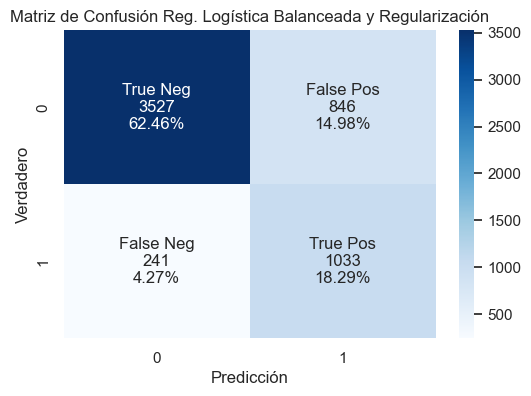

In [71]:
# Matriz de confusión con Heatmap.
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_reg.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_reg.flatten()/np.sum(cf_matrix_reg)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6, 4))  
sns.heatmap(cf_matrix_reg, annot=labels, fmt="", cmap='Blues')

plt.title('Matriz de Confusión Reg. Logística Balanceada y Regularización', fontsize=12)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

##### Curva ROC y AUC 

In [72]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reg= logistic_model_balanced_regul.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_re, tpr_re, thresholds_re = roc_curve(y_test_clean, y_probs_reg)
roc_auc_re = auc(fpr_re, tpr_re)

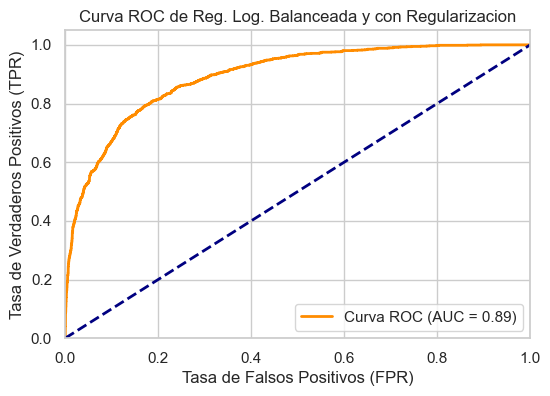

In [73]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_re, tpr_re, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_re)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada y con Regularizacion')
plt.legend(loc="lower right")
plt.show()

## 3. Modelos Base (Ingenuos) 

### Modelo Base Naive Bayes.

El clasificador Naive Bayes se considera "ingenuo" debido a la suposición simplificada que hace sobre la independencia de las características. GaussianNB: para características numéricas continuas (como temperatura, humedad, etc.) que pueden seguir una distribución normal.

In [74]:
from sklearn.naive_bayes import GaussianNB

# Crear el clasificador Naive Bayes
naive_bayes_model = GaussianNB()

# Entrenar el modelo
naive_bayes_model.fit(x_train_clean, y_train_clean)

# Hacer predicciones en el conjunto de prueba
y_pred_nb = naive_bayes_model.predict(x_test_clean)


In [75]:
# Mostrar el reporte de clasificación
print("Resultados de Naive Bayes:\n")
print(classification_report(y_test_clean, y_pred_nb))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_nb))
cf_matrix_nb= confusion_matrix(y_test_clean, y_pred_nb)


Resultados de Naive Bayes:

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4373
           1       0.56      0.69      0.62      1274

    accuracy                           0.81      5647
   macro avg       0.73      0.77      0.74      5647
weighted avg       0.83      0.81      0.81      5647

Matriz de Confusión:

[[3691  682]
 [ 400  874]]


In [76]:
# Calcular Balanced Accuracy
balanced_acc_nv= balanced_accuracy_score(y_test_clean, y_pred_nb)

print(f'Balanced Accuracy Naive Bayes: {balanced_acc_nv:.2f}')

Balanced Accuracy Naive Bayes: 0.77


In [77]:
# Obtengo las probabilidades de predicción del modelo
y_probs_nb = naive_bayes_model.predict_proba(x_test_clean)[:, 1]

# Calculo la ROC y el AUC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_clean, y_probs_nb)
roc_auc = auc(fpr_nb, tpr_nb)

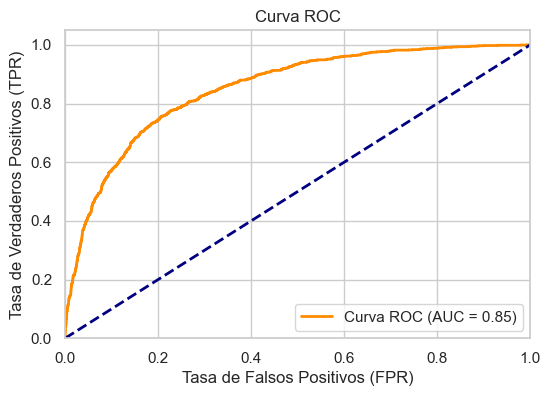

In [78]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Modelo Base: Moda.

Este modelo asigna la clase más frecuente en el conjunto de entrenamiento a todas las instancias en el conjunto de prueba.

In [79]:
# Calcular la moda
moda_result = mode(y_train_clean)       # clase_mayoritaria = "no llueve"  ( O )
clase_mas_frecuente = moda_result.mode  # es un escalar

# Predecir usando la moda
y_pred_moda = [clase_mas_frecuente] * len(y_test_clean)

# Calcular la precisión
accuracy_moda = accuracy_score(y_test_clean, y_pred_moda)

print(f"Accuracy del modelo por moda: {accuracy_moda:.2f}")


Accuracy del modelo por moda: 0.77


In [80]:
# Mostrar el reporte de clasificación
print("Resultados de Baseline por Moda:\n")
print(classification_report(y_test_clean, y_pred_moda))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_moda))

Resultados de Baseline por Moda:

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4373
           1       0.00      0.00      0.00      1274

    accuracy                           0.77      5647
   macro avg       0.39      0.50      0.44      5647
weighted avg       0.60      0.77      0.68      5647

Matriz de Confusión:

[[4373    0]
 [1274    0]]


In [81]:
# Calcular Balanced Accuracy
balanced_acc_moda= balanced_accuracy_score(y_test_clean, y_pred_moda)

print(f'Balanced Accuracy Moda: {balanced_acc_moda:.2f}')

Balanced Accuracy Moda: 0.50


Interpretacion:
4373: Verdaderos negativos (TN). Son los casos donde se predijo correctamente la clase negativa (que es la clase mayoritaria en tu dataset).

0: Falsos positivos (FP). No hay predicciones incorrectas de la clase positiva.

1274: Falsos negativos (FN). Estos son los casos donde la clase real es positiva, pero se predijo como negativa (la clase mayoritaria).

0: Verdaderos positivos (VP). No hay predicciones correctas para la clase 

La curva ROC no se puede calcular, ya que no es un modelo entrenado que devuelva probabilidades (sino predicciones constantes). Como se usa la moda para predecir, simplemente se asigna a todas las instancias el valor de la clase más frecuente.
La moda, al ser una predicción fija (por ejemplo, "no llueve" para todos los casos), no proporciona variabilidad en las predicciones necesarias para trazar la curva.


## Comparación de Modelos

- Precisión (Accuracy): Es la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones realizadas.
    - Correctas / Totales

- Recall (Recall o Sensibilidad): Es la proporción de instancias positivas que el modelo predijo correctamente respecto a todas las instancias positivas reales.
    - VP / (VP + FN)

- F1-score: Es la media armónica de precisión y recall. Proporciona una medida única que combina ambos aspectos del rendimiento del modelo.
    - Precisión x Recall / (Precisión + Recall)

- Soporte (Support): Es el número de instancias en el conjunto de datos que pertenecen a cada clase. Ayuda a entender cuán representativas son las muestras de cada clase.

ANTES DE AJUSTAR UMBRALES

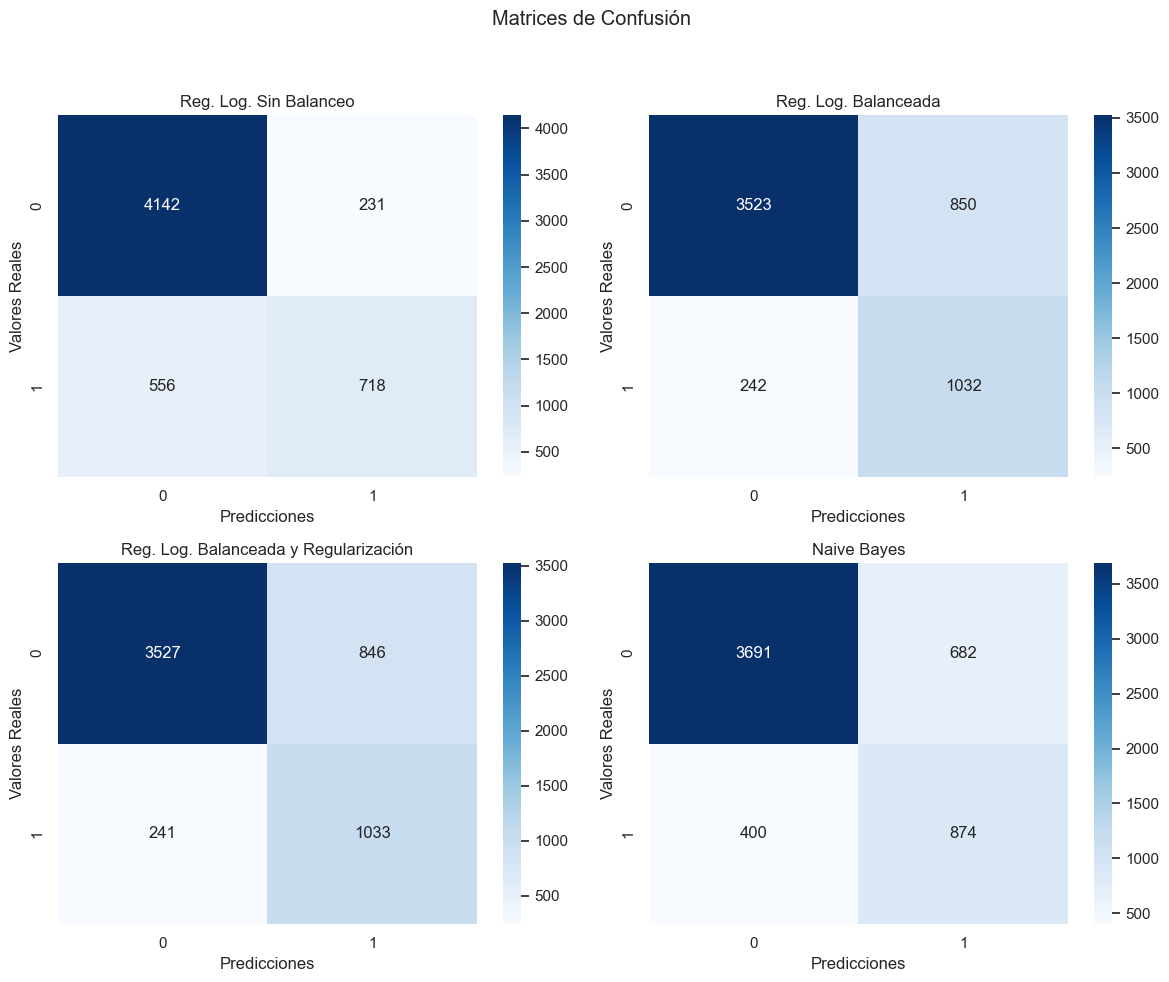

In [82]:
# Crea una figura con cuatro subgráficos
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Título para toda la figura
fig.suptitle("Matrices de Confusión")

# Títulos para cada subgráfico
titles = ["Reg. Log. Sin Balanceo", "Reg. Log. Balanceada", "Reg. Log. Balanceada y Regularización", "Naive Bayes"]

# Matrices de confusión
matrices = [cf_matrix, cf_matrix_b, cf_matrix_reg, cf_matrix_nb]

for i, ax in enumerate(axes.ravel()):
    sns.heatmap(matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicciones")
    ax.set_ylabel("Valores Reales")
    ax.set_title(titles[i])

# Ajusta la disposición de los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Observamos que al Balancear mediante la discriminación de penalidad asignada a cada clase, para evitar que modelo tienda a predecir la categoría mayoritaria, se mejora el recall de la clase minoritaria, pasando de 0.57 a 0.8, que en TP se traduce en 725 a 1020 aciertos. 

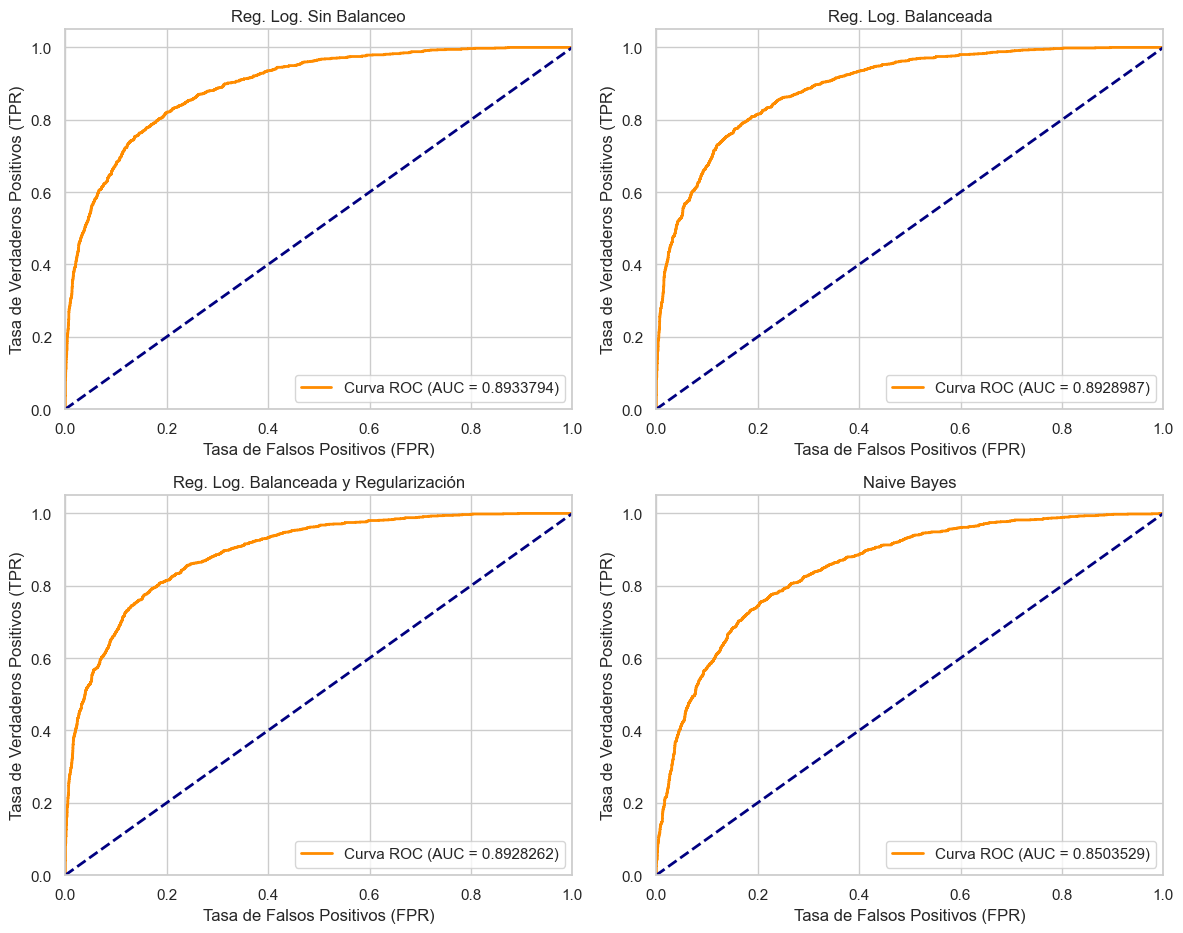

In [83]:
# Crear una figura con cuatro subgráficos
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Títulos para cada subgráfico
titles = ["Reg. Log. Sin Balanceo", "Reg. Log. Balanceada", "Reg. Log. Balanceada y Regularización", "Naive Bayes"]

# Probabilidades y etiquetas de prueba para cada modelo
y_probs_modelos = [y_probs_reglog, y_probs_balanced, y_probs_reg, y_probs_nb]

for i, ax in enumerate(axes.ravel()):
    fpr, tpr, thresholds = roc_curve(y_test_clean, y_probs_modelos[i])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
    ax.set_title(titles[i])
    ax.legend(loc="lower right")

# Ajusta la disposición de los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [84]:
# Generar los informes de clasificación
report_reglog = classification_report(y_test_clean, y_pred, output_dict=True)
report_balanced = classification_report(y_test_clean, y_pred_balanced, output_dict=True)
report_regularized = classification_report(y_test_clean, y_pred_reg, output_dict=True)
report_base_nb = classification_report(y_test_clean, y_pred_nb, output_dict=True)

#### Cuadro comparativo métricas.

Realizamos una observación general de todas las métricas.

In [85]:
# Extraer las métricas ( crea del df de métricas
metrics = {
    "Modelo": [
        "Regresión Logística", 
        "Regres. Log. Balanceada", 
        "Reg. Log. Balanc. Regularizada", 
        "Naive Bayes"
    ],
    "Accuracy": [
        report_reglog["accuracy"],
        report_balanced["accuracy"],
        report_regularized["accuracy"],
        report_base_nb["accuracy"]
    ],
    "Precision (Clase 0)": [
        report_reglog["0"]["precision"],
        report_balanced["0"]["precision"],
        report_regularized["0"]["precision"],
        report_base_nb["0"]["precision"]
    ],
    "Precision (Clase 1)": [
        report_reglog["1"]["precision"],
        report_balanced["1"]["precision"],
        report_regularized["1"]["precision"],
        report_base_nb["1"]["precision"]
    ],
    "Recall (Clase 0)": [
        report_reglog["0"]["recall"],
        report_balanced["0"]["recall"],
        report_regularized["0"]["recall"],
        report_base_nb["0"]["recall"]
    ],
    "Recall (Clase 1)": [
        report_reglog["1"]["recall"],
        report_balanced["1"]["recall"],
        report_regularized["1"]["recall"],
        report_base_nb["1"]["recall"]
    ],
    "F1 Score (Clase 0)": [
        report_reglog["0"]["f1-score"],
        report_balanced["0"]["f1-score"],
        report_regularized["0"]["f1-score"],
        report_base_nb["0"]["f1-score"]
    ],
    "F1 Score (Clase 1)": [
        report_reglog["1"]["f1-score"],
        report_balanced["1"]["f1-score"],
        report_regularized["1"]["f1-score"],
        report_base_nb["1"]["f1-score"]
    ],
    "Balanced Accuracy": [
        balanced_acc_rl, 
        balanced_acc_balanced, 
        balanced_acc_reg, 
        balanced_acc_nv
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


,Modelo,Accuracy,Precision (Clase 0),Precision (Clase 1),Recall (Clase 0),Recall (Clase 1),F1 Score (Clase 0),F1 Score (Clase 1),Balanced Accuracy
0,Regresión Logística,0.860634,0.881652,0.756586,0.947176,0.563579,0.913240,0.645974,0.755378
1,Regres. Log. Balanceada,0.806623,0.935724,0.548353,0.805625,0.810047,0.865815,0.653992,0.807836
2,Reg. Log. Balanc. Regularizada,0.807508,0.936040,0.549761,0.806540,0.810832,0.866478,0.655249,0.808686
3,Naive Bayes,0.808394,0.902224,0.561697,0.844043,0.686028,0.872164,0.617668,0.765036


In [89]:
# GRÁFICO DE BARRAS DE MÉTRICAS SEPARADAS POR CLASES.
# Usar melt para incluir tanto la clase 0 como la clase 1 (La función melt() transforma el DataFrame para que las métricas estén en una forma "larga" en lugar de "ancha")
metrics_melted = metrics_df.melt(id_vars=["Modelo"], 
                                   value_vars=["Precision (Clase 0)", "Precision (Clase 1)", 
                                               "Recall (Clase 0)", "Recall (Clase 1)", 
                                               "F1 Score (Clase 0)", "F1 Score (Clase 1)"],
                                   var_name="Métrica", 
                                   value_name="Valor")

# Crear el gráfico de barras
fig = px.bar(metrics_melted, 
             x='Modelo', 
             y='Valor', 
             color='Métrica', 
             barmode='group',
             title='Comparativa de Métricas por Modelo y por clases')

fig.show()


#### Umbral óptimo.

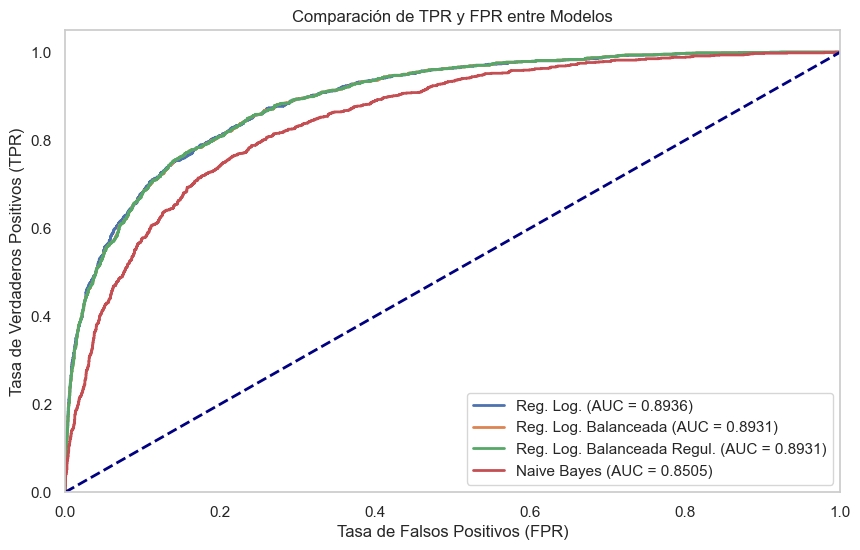

In [138]:
# Relación entre TPR/FPR de Curva ROC y AUC.

# Definir los modelos y sus TPR y FPR
model_names = ["Reg. Log.", "Reg. Log. Balanceada", "Reg. Log. Balanceada Regul.", "Naive Bayes"]
tpr_values = [tpr_rl, tpr_ba, tpr_re, tpr_nb]
fpr_values = [fpr_rl, fpr_ba, fpr_re, fpr_nb]
y_probs_modelos = [y_probs_reglog, y_probs_balanced, y_probs_reg, y_probs_nb]  # Probabilidades de cada modelo

# Crear el gráfico
plt.figure(figsize=(10, 6))

for i, model in enumerate(model_names):
    # Calcular AUC para cada modelo
    auc_value = roc_auc_score(y_test_clean, y_probs_modelos[i])
    
    # Graficar TPR vs FPR
    plt.plot(fpr_values[i], tpr_values[i], lw=2, label=f'{model} (AUC = {auc_value:.4f})')

# Agregar líneas de referencia
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal

# Configurar el gráfico
plt.title("Comparación de TPR y FPR entre Modelos")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.grid()

# Mostrar el gráfico
plt.show()


Umbral óptimo: Calcular la distancia euclidiana de cada punto de la curva ROC a punto(0,1) o AUC=1.

Nos interesa la distancia mínima: qué tan "cerca" se encuentra de la esquina superior izquierda de la curva ROC, lo que indica un mejor equilibrio entre la tasa de verdaderos positivos y la tasa de falsos positivos.

$\text{distancia} = \sqrt{(\text{FPR})^2 + (1 - \text{TPR})^2}$

Objetivo: Ajustar umbrales para maximizar el F1 score y el balanced accuracy.

Pasos: 1) Obtener las Probabilidades de la Clase Positiva

       2) Curva ROC y los Umbrales : función roc_curve para calcular la TPR, FPR y los umbrales para cada modelo.

       3) Encontrar el Umbral Óptimo: 

       4) Hacer Predicciones Usando el Umbral Óptimo
       
       5) Evaluar el Rendimiento: F1 score y el balanced accuracy para cada modelo utilizando las predicciones ajustadas

NOTA: 

Cálculos ya realizados con antelación por modelo.:

**Predicciones de los distintos modelos:**
y_pred ,
y_pred_balanced ,
y_pred_reg ,
y_pred_nb ,
y_pred_moda

**1) Predicciones de Probabilidades**  

Probabilidades de las clases positivas para cada uno de los modelos (método predict_proba):

y_probs_reglog= logistic_model.predict_proba(x_test_clean)[:, 1] 

y_probs_balanced = logistic_model_balanced.predict_proba(x_test_clean)[:, 1]

y_probs_reg = logistic_model_balanced_regul.predict_proba(x_test_clean)[:, 1]

y_probs_nb = naive_bayes_model.predict_proba(x_test_clean)[:, 1]

y_probs_moda: No se puede calcular de la misma manera que las probabilidades. La moda no tiene un valor de probabilidad, ya que simplemente se asigna la clase mayoritaria sin considerar probabilidades. Por lo tanto, no se genera a partir de predict_proba.

**2) Curva ROC y los Umbrales ( thresholds) : función roc_curve para calcular la TPR, FPR y los umbrales para cada modelo.**

Mejor umbral: 0.5481211805112595
Distancia mínima al punto perfecto: 0.27491788516366916


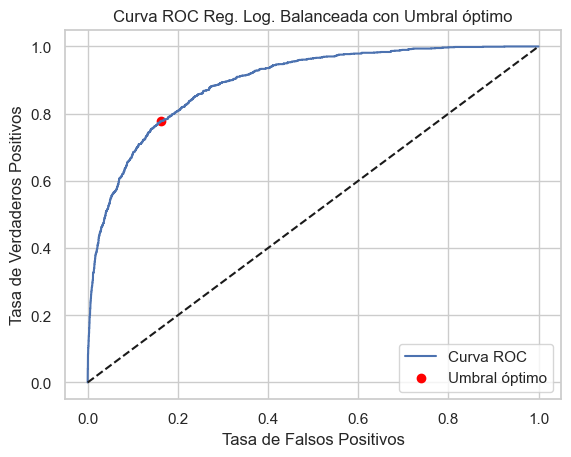

In [145]:
# Observamos Gráficamente Umbral Optimo unicamente para Reg. Logistica Balanceada (distancia a punto (0,1) --> donde AUC = 1)
"""Calcula la curva ROC con las etiquetas verdaderas y las probabilidades de clase positiva.
   Calcula la distancia euclidiana de cada punto de la curva al punto perfecto (0,1).
   Encuentra el umbral que minimiza esta distancia
"""

# Calcular la distancia al punto perfecto
distances = np.sqrt(fpr_ba**2 + (1 - tpr_ba)**2)

# Encontrar el índice del umbral que minimiza la distancia
min_distance_index = np.argmin(distances)
best_threshold = thresholds_ba[min_distance_index]
best_distance = distances[min_distance_index]

print("Mejor umbral:", best_threshold)
print("Distancia mínima al punto perfecto:", best_distance)

import matplotlib.pyplot as plt

plt.plot(fpr_ba, tpr_ba, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.scatter(fpr_ba[min_distance_index], tpr_ba[min_distance_index], color='red', label='Umbral óptimo')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Reg. Log. Balanceada con Umbral óptimo')
plt.legend()
plt.show()

In [146]:
# 3) Umbral Óptimo para cada modelo y distancia mínima que los determina.
def find_optimal_threshold(fpr, tpr, thresholds):
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)  # Distancia
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]
    minimum_distance = distances[optimal_idx]
    return optimal_threshold, minimum_distance

# Encontrar umbrales óptimos
optimal_threshold_reglog, min_distance_reglog = find_optimal_threshold(fpr_rl, tpr_rl, thresholds_rl)
optimal_threshold_balanced, min_distance_balanced = find_optimal_threshold(fpr_ba, tpr_ba, thresholds_ba)
optimal_threshold_reg, min_distance_reg = find_optimal_threshold(fpr_re, tpr_re, thresholds_re)
optimal_threshold_nb, min_distance_nb = find_optimal_threshold(fpr_nb, tpr_nb, thresholds_nb)

# Imprimir resultados
print(f'Umbral óptimo (Reg. Log.): {optimal_threshold_reglog:.2f}, Distancia mínima: {min_distance_reglog:.4f}')
print(f'Umbral óptimo (Reg. Log. Balanceada): {optimal_threshold_balanced:.2f}, Distancia mínima: {min_distance_balanced:.4f}')
print(f'Umbral óptimo (Reg. Log. Balanceada Regul.): {optimal_threshold_reg:.2f}, Distancia mínima: {min_distance_reg:.4f}')
print(f'Umbral óptimo (Naive Bayes): {optimal_threshold_nb:.2f}, Distancia mínima: {min_distance_nb:.4f}')


Umbral óptimo (Reg. Log.): 0.23, Distancia mínima: 0.2732
Umbral óptimo (Reg. Log. Balanceada): 0.55, Distancia mínima: 0.2749
Umbral óptimo (Reg. Log. Balanceada Regul.): 0.55, Distancia mínima: 0.2751
Umbral óptimo (Naive Bayes): 0.17, Distancia mínima: 0.3197


In [129]:
# 4) Predicciones finales usando los umbrales óptimos
y_pred_optimal_reglog = (y_probs_reglog >= optimal_threshold_reglog).astype(int)
y_pred_optimal_balanced = (y_probs_balanced >= optimal_threshold_balanced).astype(int)
y_pred_optimal_reg = (y_probs_reg >= optimal_threshold_reg).astype(int)
y_pred_optimal_nb = (y_probs_nb >= optimal_threshold_nb).astype(int)

In [150]:
# 5) Observación de rendimiento general de todas las métricas con ajuste de umbral.
"""
# F1 Score y Balanced Accuracy para el modelo base
f1_reglog = f1_score(y_test_clean, y_pred_optimal_reglog)
balanced_acc_reglog = balanced_accuracy_score(y_test_clean, y_pred_optimal_reglog)
print(f'F1 Score (Reg. Log.): {f1_reglog:.4f}, Balanced Accuracy: {balanced_acc_reglog:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_reglog))

# F1 Score y Balanced Accuracy para el modelo balanceado
f1_balanced = f1_score(y_test_clean, y_pred_optimal_balanced)
balanced_acc_balanced = balanced_accuracy_score(y_test_clean, y_pred_optimal_balanced)
print(f'F1 Score (Reg. Log. Balanceada): {f1_balanced:.4f}, Balanced Accuracy: {balanced_acc_balanced:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_balanced))

# F1 Score y Balanced Accuracy para el modelo balanceado regulado
f1_reg = f1_score(y_test_clean, y_pred_optimal_reg)
balanced_acc_reg = balanced_accuracy_score(y_test_clean, y_pred_optimal_reg)
print(f'F1 Score (Reg. Log. Balanceada Regul.): {f1_reg:.4f}, Balanced Accuracy: {balanced_acc_reg:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_reg))

# F1 Score y Balanced Accuracy para Naive Bayes
f1_nb = f1_score(y_test_clean, y_pred_optimal_nb)
balanced_acc_nb = balanced_accuracy_score(y_test_clean, y_pred_optimal_nb)
print(f'F1 Score (Naive Bayes): {f1_nb:.4f}, Balanced Accuracy: {balanced_acc_nb:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_nb))
"""

"\n# F1 Score y Balanced Accuracy para el modelo base\nf1_reglog = f1_score(y_test_clean, y_pred_optimal_reglog)\nbalanced_acc_reglog = balanced_accuracy_score(y_test_clean, y_pred_optimal_reglog)\nprint(f'F1 Score (Reg. Log.): {f1_reglog:.4f}, Balanced Accuracy: {balanced_acc_reglog:.4f}')\nprint(classification_report(y_test_clean, y_pred_optimal_reglog))\n\n# F1 Score y Balanced Accuracy para el modelo balanceado\nf1_balanced = f1_score(y_test_clean, y_pred_optimal_balanced)\nbalanced_acc_balanced = balanced_accuracy_score(y_test_clean, y_pred_optimal_balanced)\nprint(f'F1 Score (Reg. Log. Balanceada): {f1_balanced:.4f}, Balanced Accuracy: {balanced_acc_balanced:.4f}')\nprint(classification_report(y_test_clean, y_pred_optimal_balanced))\n\n# F1 Score y Balanced Accuracy para el modelo balanceado regulado\nf1_reg = f1_score(y_test_clean, y_pred_optimal_reg)\nbalanced_acc_reg = balanced_accuracy_score(y_test_clean, y_pred_optimal_reg)\nprint(f'F1 Score (Reg. Log. Balanceada Regul.): {f

In [151]:
# 5) Observación de rendimiento general de todas las métricas con ajuste de umbral (métricas con umbral óptimo)
metrics = {
    "Modelo": [
        "Regresión Logística", 
        "Regres. Log. Balanceada", 
        "Reg. Log. Balanc. Regularizada", 
        "Naive Bayes"
    ],
    "Accuracy": [
        accuracy_score(y_test_clean, y_pred_optimal_reglog),
        accuracy_score(y_test_clean, y_pred_optimal_balanced),
        accuracy_score(y_test_clean, y_pred_optimal_reg),
        accuracy_score(y_test_clean, y_pred_optimal_nb)
    ],
    "Precision (Clase 0)": [
        precision_score(y_test_clean, y_pred_optimal_reglog, pos_label=0),
        precision_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        precision_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        precision_score(y_test_clean, y_pred_optimal_nb, pos_label=0)
    ],
    "Precision (Clase 1)": [
        precision_score(y_test_clean, y_pred_optimal_reglog, pos_label=1),
        precision_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        precision_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        precision_score(y_test_clean, y_pred_optimal_nb, pos_label=1)
    ],
    "Recall (Clase 0)": [
        recall_score(y_test_clean, y_pred_optimal_reglog, pos_label=0),
        recall_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        recall_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        recall_score(y_test_clean, y_pred_optimal_nb, pos_label=0)
    ],
    "Recall (Clase 1)": [
        recall_score(y_test_clean, y_pred_optimal_reglog, pos_label=1),
        recall_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        recall_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        recall_score(y_test_clean, y_pred_optimal_nb, pos_label=1)
    ],
    "F1 Score (Clase 0)": [
        f1_score(y_test_clean, y_pred_optimal_reglog, pos_label=0),
        f1_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        f1_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        f1_score(y_test_clean, y_pred_optimal_nb, pos_label=0)
    ],
    "F1 Score (Clase 1)": [
        f1_score(y_test_clean, y_pred_optimal_reglog, pos_label=1),
        f1_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        f1_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        f1_score(y_test_clean, y_pred_optimal_nb, pos_label=1)
    ],
    "Balanced Accuracy": [
        balanced_accuracy_score(y_test_clean, y_pred_optimal_reglog), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_balanced), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_reg), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_nb)
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


,Modelo,Accuracy,Precision (Clase 0),Precision (Clase 1),Recall (Clase 0),Recall (Clase 1),F1 Score (Clase 0),F1 Score (Clase 1),Balanced Accuracy
0,Regresión Logística,0.809456,0.933702,0.553629,0.811571,0.802198,0.868363,0.655128,0.806884
1,Regres. Log. Balanceada,0.823800,0.928463,0.581818,0.836954,0.778650,0.880337,0.665995,0.807802
2,Reg. Log. Balanc. Regularizada,0.823623,0.928445,0.581477,0.836725,0.778650,0.880202,0.665772,0.807688
3,Naive Bayes,0.779883,0.919346,0.508094,0.784587,0.763736,0.846638,0.610223,0.774162


### Cuadro comparativo con ajuste de Umbral óptimo ( solo Recal 1, F1-Score, Balanced Accuracy)

In [134]:
# Calcular las métricas para cada modelo con el umbral óptimo
metrics = {
    "Modelo": [
        "Regresión Logística", 
        "Regres. Log. Balanceada", 
        "Reg. Log. Balanceada y Regularizada", 
        "Naive Bayes"
    ],
    "F1 Score": [
        f1_score(y_test_clean, y_pred_optimal_reglog),
        f1_score(y_test_clean, y_pred_optimal_balanced),
        f1_score(y_test_clean, y_pred_optimal_reg),
        f1_score(y_test_clean, y_pred_optimal_nb)
    ],
    "Balanced Accuracy": [
        balanced_accuracy_score(y_test_clean, y_pred_optimal_reglog), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_balanced), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_reg), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_nb)
    ],
    "Recall (Clase 1)": [
        classification_report(y_test_clean, y_pred_optimal_reglog, output_dict=True)["1"]["recall"],
        classification_report(y_test_clean, y_pred_optimal_balanced, output_dict=True)["1"]["recall"],
        classification_report(y_test_clean, y_pred_optimal_reg, output_dict=True)["1"]["recall"],
        classification_report(y_test_clean, y_pred_optimal_nb, output_dict=True)["1"]["recall"]
    ]
}

# Convertir a DataFrame
metrics_df_umbral = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df_umbral.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


,Modelo,F1 Score,Balanced Accuracy,Recall (Clase 1)
0,Regresión Logística,0.655128,0.806884,0.802198
1,Regres. Log. Balanceada,0.665995,0.807802,0.778650
2,Reg. Log. Balanceada y Regularizada,0.665772,0.807688,0.778650
3,Naive Bayes,0.610223,0.774162,0.763736


## Conclusión Final

Resultados obtenidos con ajustes de los modelos con umbrales óptimos en relación a métricas sin ajuste de umbral:


Comparación entre modelos:
El modelo que se destaca es la **Regresión Logística Balanceada**, que presenta el mejor F1 Score (0.665995) y un Balanced Accuracy  de 0.807802. Aunque su Recall para la clase 1 (0.778650) es ligeramente inferior al de la Regresión Logística (0.8022), el balanceo en este modelo ayuda a prevenir el sesgo hacia la clase mayoritaria, lo cual es crucial en un dataset donde la clase "no llueve" ( clase 0) es mayoritaria.

En el contexto de los datos proporcionados, nos interesa maximizar el Recall 1, que implica maximizar los verdaderos positivos (TP) y minimizar los Falsos Negativos ( error tipo 2). 
 No obsatnte, vamos a observar el comportamiento general del modelo con la métrica **Balanced accuracy**, dado que esta métrica proporciona una evaluación equilibrada del rendimiento del modelo para ambas clases, lo que es crucial en situaciones de desbalance significativo. Nos interesa ver que no estemos sacrificando el rendimiento de la clase mayoritaria en post del incremento del rendimiento de la clase minoritaria.
  (Recordemos que la target que indica "si llueve" (Clase positiva: RainTomorrow = 1) es la minoritaria y "no llueve" (Clase negativa =0), donde "no llueve" es la clase mayoritaria.)
